# Bitcoin Volatility Prediction

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from pmdarima import auto_arima
from arch import arch_model
import arch
import itertools
import os

# Stationary
import statsmodels.graphics.tsaplots as sgt #ACF, PACF
from statsmodels.tsa.stattools import adfuller #ADF
from statsmodels.tsa.stattools import kpss #KPSS
import warnings #경고 무시

import pmdarima as pm #auto_arima
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm

#time
import time

In [2]:
## 기본 설정 값

# fig
figsize=(15,5)

# 경고 무시 설정
warnings.filterwarnings('ignore')
# KPSS에서 경고가 하나 떴는데 큰 영향을 미치지 않는다고 하여 작성
# 경고 무시 설정은 다른 코드들 작성할 때 주석 처리해 가며 확인 필요

- 주최측 제공 함수

In [3]:
def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """

    data['time'] = pd.to_datetime(data['time'], unit='ms')
    ohlcv = data.resample('1H', on='time').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'price': 'mean',
        'quote_qty': 'std',
        'is_buyer_maker': 'sum'
        
})

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

### Loading Data

In [4]:
df = pd.read_csv('../data/BIT_2023_1차.csv')
df.set_index('time', inplace=True)
df.index=pd.to_datetime(df.index)

In [5]:
#################### dfc가 결측치 포함된 원본 데이터입니다 #####################
dfc=df.copy()

In [6]:
df.isnull().sum()

Open               24
High               24
Low                24
Close              24
Volume              0
returns            12
volatility        186
price              24
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

## 1. Preprocessing

### 1-1. Checking Missing Value

#### - price(Open, High, Low, Close, price), quote_qty, quote_qty_cal

In [7]:
display(df[df['price'].isnull()].index)

DatetimeIndex(['2023-01-23 21:00:00', '2023-01-23 22:00:00',
               '2023-01-23 23:00:00', '2023-01-24 21:00:00',
               '2023-01-24 22:00:00', '2023-01-24 23:00:00',
               '2023-01-25 16:00:00', '2023-01-25 17:00:00',
               '2023-01-25 18:00:00', '2023-01-25 19:00:00',
               '2023-01-25 20:00:00', '2023-01-25 21:00:00',
               '2023-01-25 22:00:00', '2023-01-25 23:00:00',
               '2023-01-26 22:00:00', '2023-01-26 23:00:00',
               '2023-03-14 23:00:00', '2023-03-15 22:00:00',
               '2023-03-15 23:00:00', '2023-11-21 03:00:00',
               '2023-11-21 04:00:00', '2023-11-21 05:00:00',
               '2023-11-21 06:00:00', '2023-11-21 07:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [8]:
# spline 보간
def spline_interpolate_column(df, column_name, order=3):
    df[column_name] = df[column_name].interpolate(method='spline', order=order)

In [9]:
columns_to_interpolate = ['Open', 'High', 'Low', 'Close','price']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=3)

In [13]:
columns_to_interpolate_volume = ['quote_qty','quote_qty_cal']

for column in columns_to_interpolate:
    spline_interpolate_column(df, column, order=3)

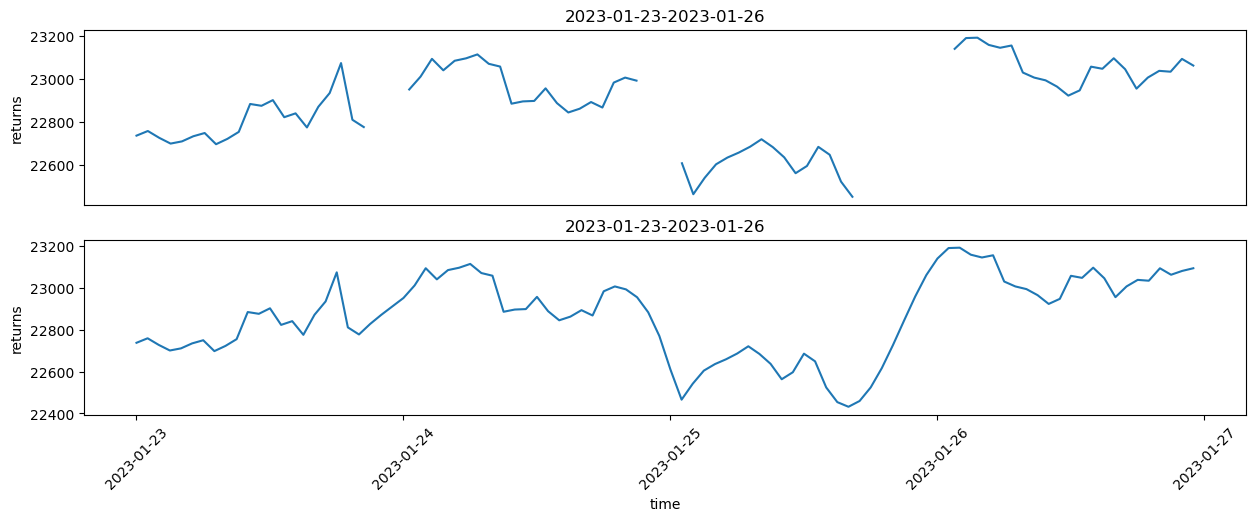

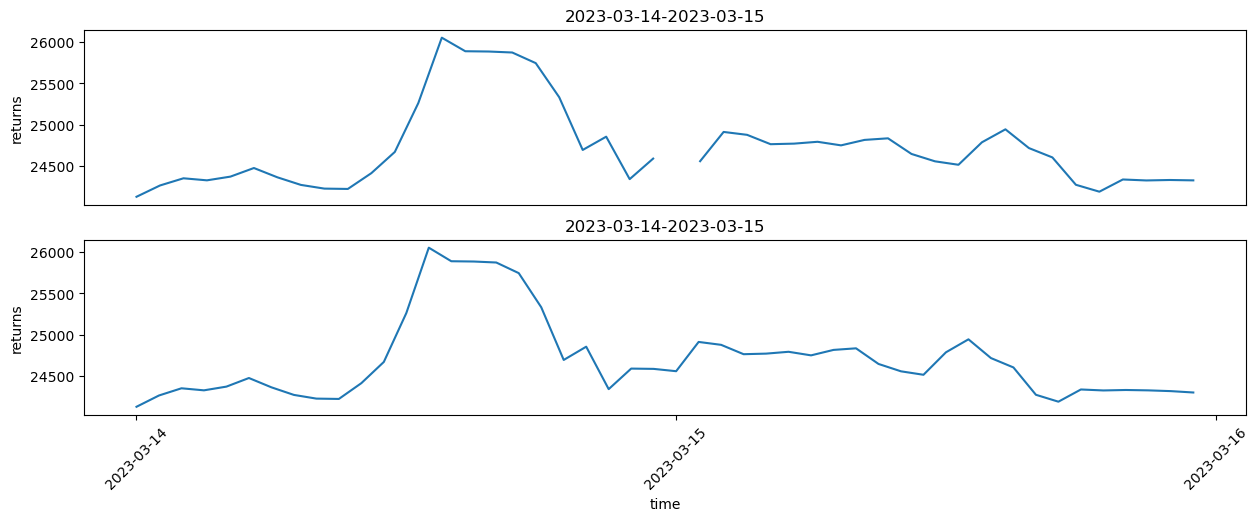

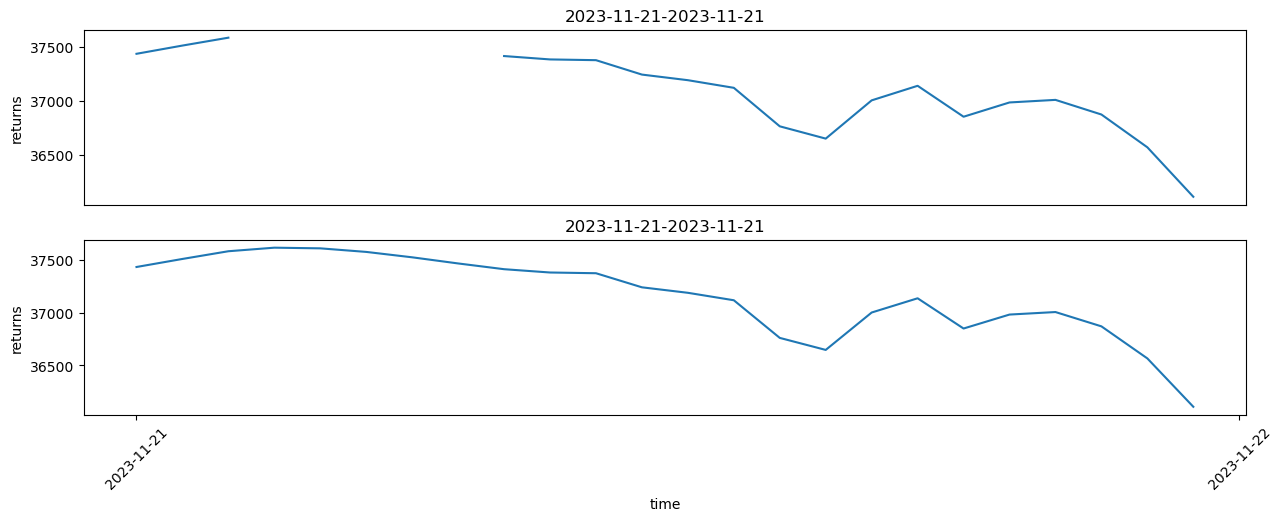

In [11]:
def Visualizing_returns(dfc, df, start_date, end_date, figsize=(15,5)):
    
    df_filtered = df.loc[start_date:end_date]
    dfc_filtered = dfc.loc[start_date:end_date]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax[0].plot(df_filtered.index, dfc_filtered)
    ax[0].set_ylabel('returns')
    ax[0].set_title(f'{start_date}-{end_date}')
    ax[0].set_xticks([])

    ax[1].plot(df_filtered.index, df_filtered)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('returns')
    ax[1].set_title(f'{start_date}-{end_date}')
    
    ax[1].xaxis.set_major_locator(mdates.DayLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.show()
    
Visualizing_returns(dfc['price'], df['price'],'2023-01-23', '2023-01-26')
Visualizing_returns(dfc['price'], df['price'],'2023-03-14', '2023-03-15')
Visualizing_returns(dfc['price'], df['price'],'2023-11-21', '2023-11-21')

In [14]:
df.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
returns            12
volatility        186
price               0
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

#### - returns

In [12]:
df[df['returns'].isnull()].index # 매달 1일 1시간

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [13]:
# auto_arima 사용을 위한 drop
df_returns=df['returns'].dropna()

In [14]:
# auto_arima
autoarima_model = pm.auto_arima(df_returns, suppress_warnings=True)
print(autoarima_model)

 ARIMA(1,0,2)(0,0,0)[0] intercept


In [15]:
# 결측치 보간을 위한 ARIMA 모델 훈련 함수

def interpolate_arima(data):
    
    # 결측치 보간 전 ARIMA 모델 훈련
    model = sm.tsa.ARIMA(data.dropna(), order=(1, 0, 2))  # p, d, q는 ARIMA 모델의 차수
    results = model.fit()


    # 보간할 결측치 선택
    missing_indices = data[data.isnull()].index

    # 결측치 보간
    for idx in missing_indices:
        # ARIMA 모델을 사용하여 결측치 예측
        predicted_value = results.get_forecast(steps=1).predicted_mean.iloc[0]  # 예측 결과의 첫 번째 값을 사용

        # 결측치 보간
        data[idx] = predicted_value


# 시계열 데이터에 대한 결측치 보간
interpolate_arima(df['returns'])

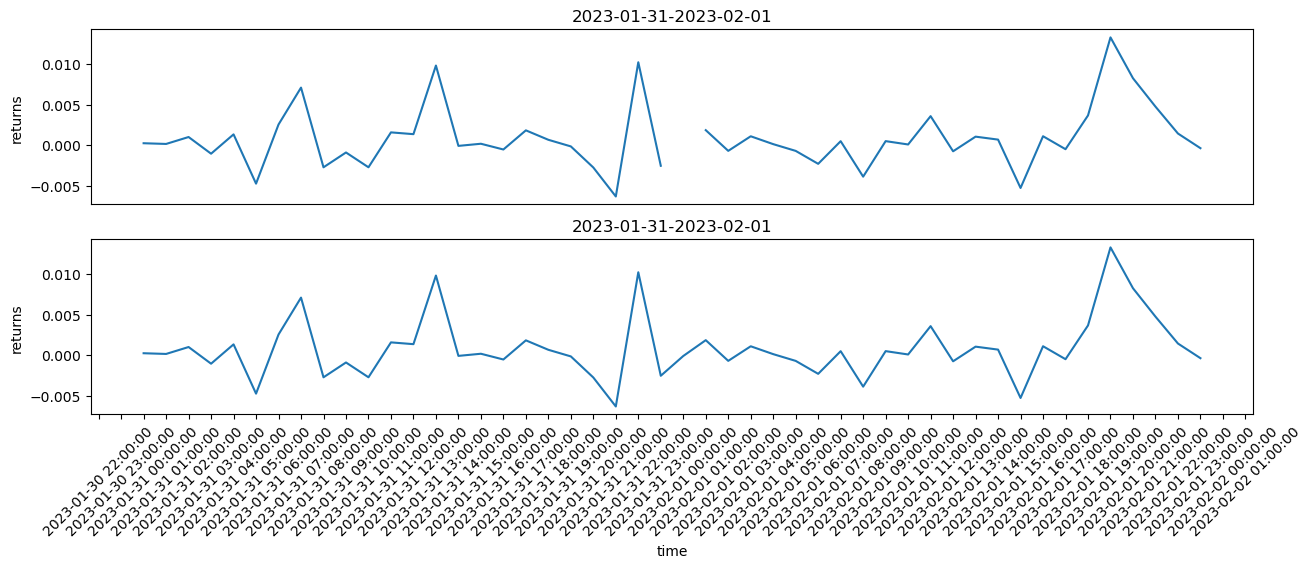

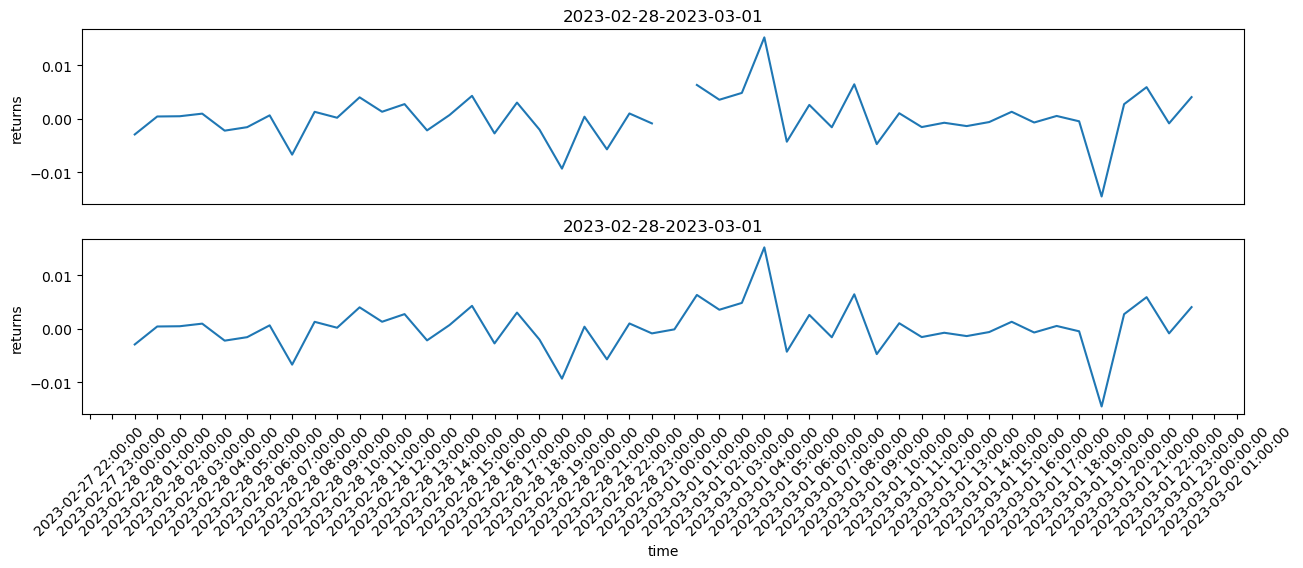

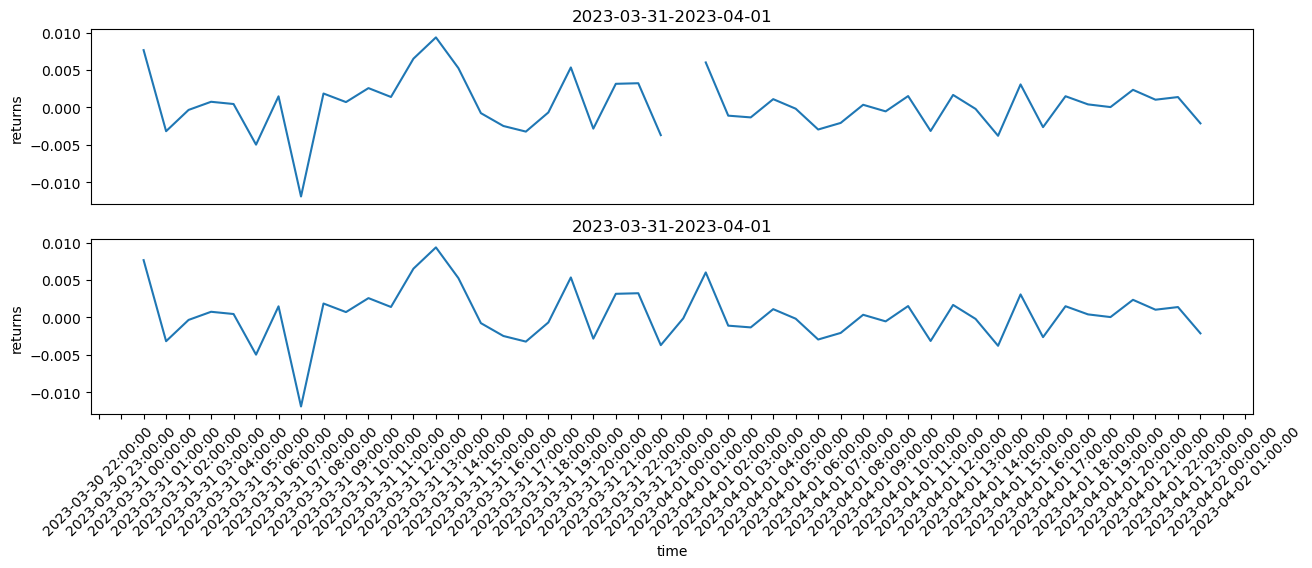

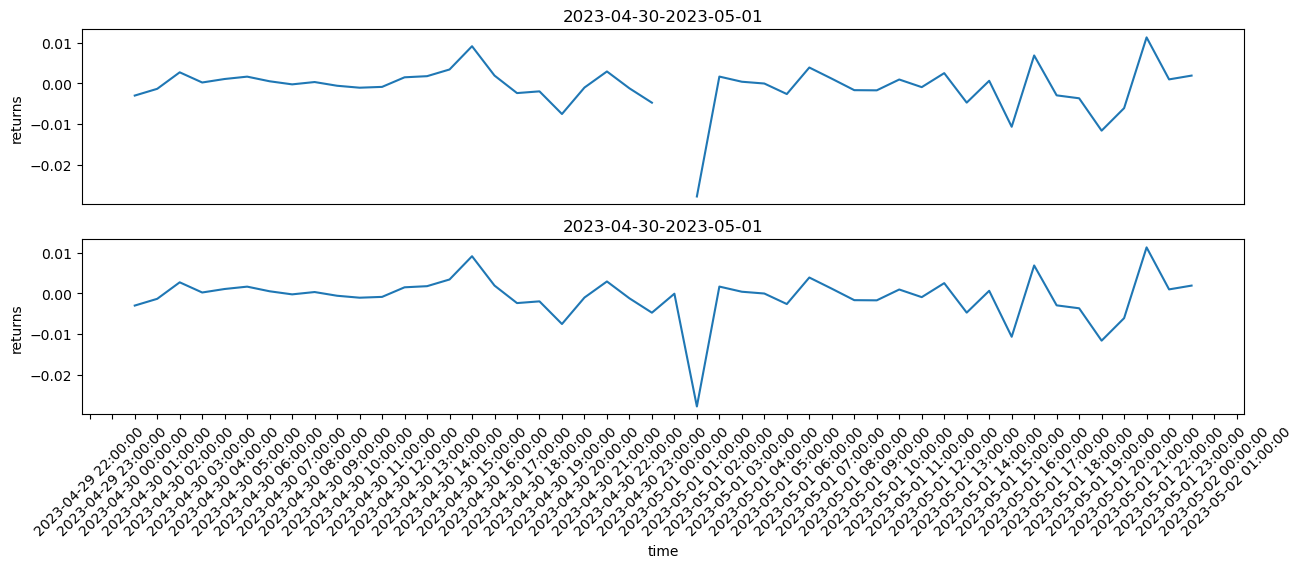

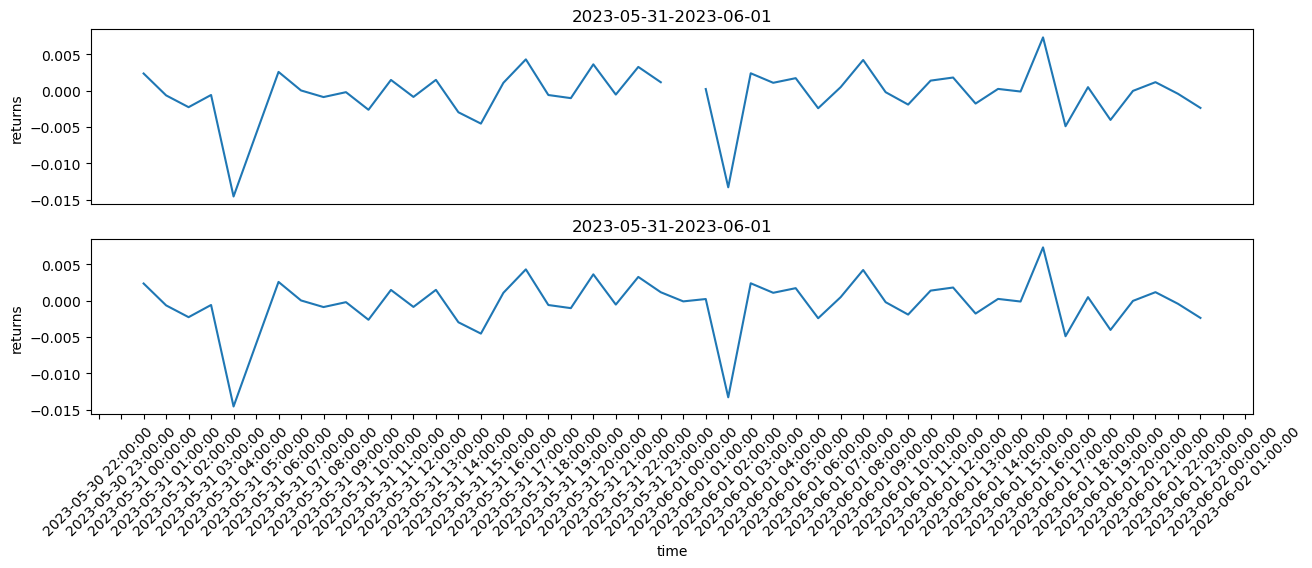

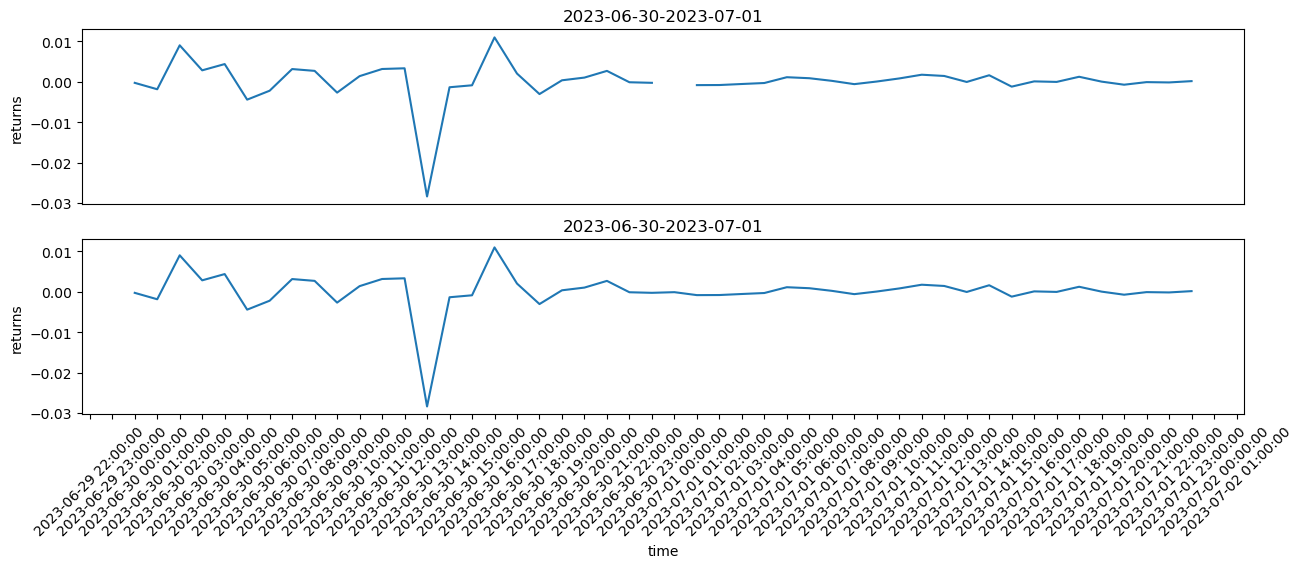

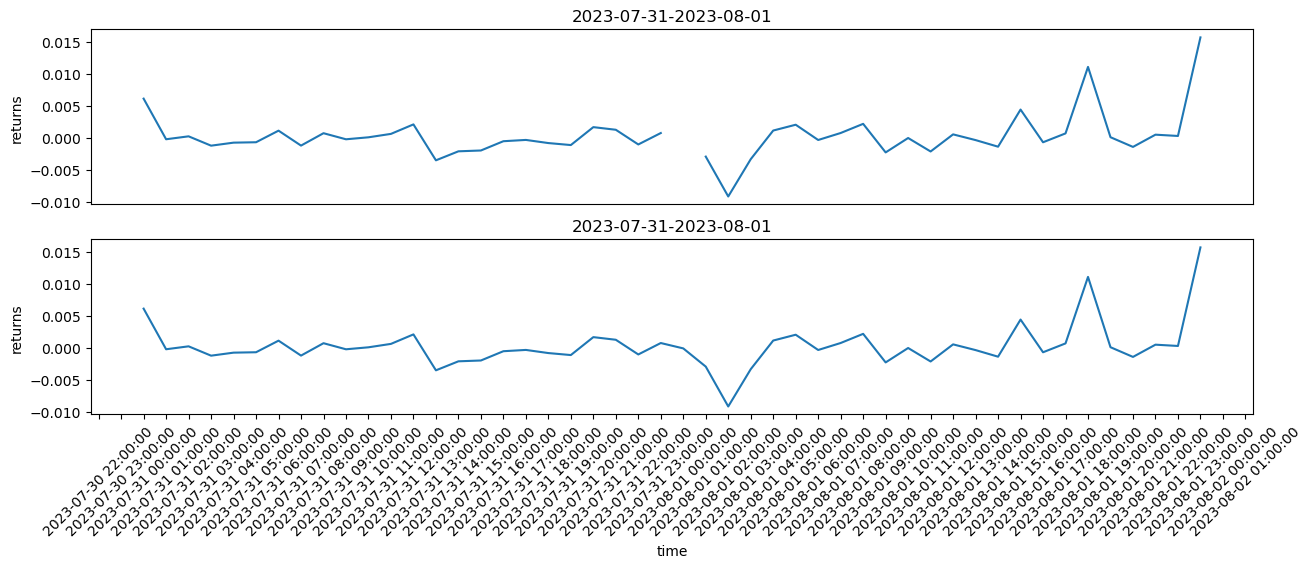

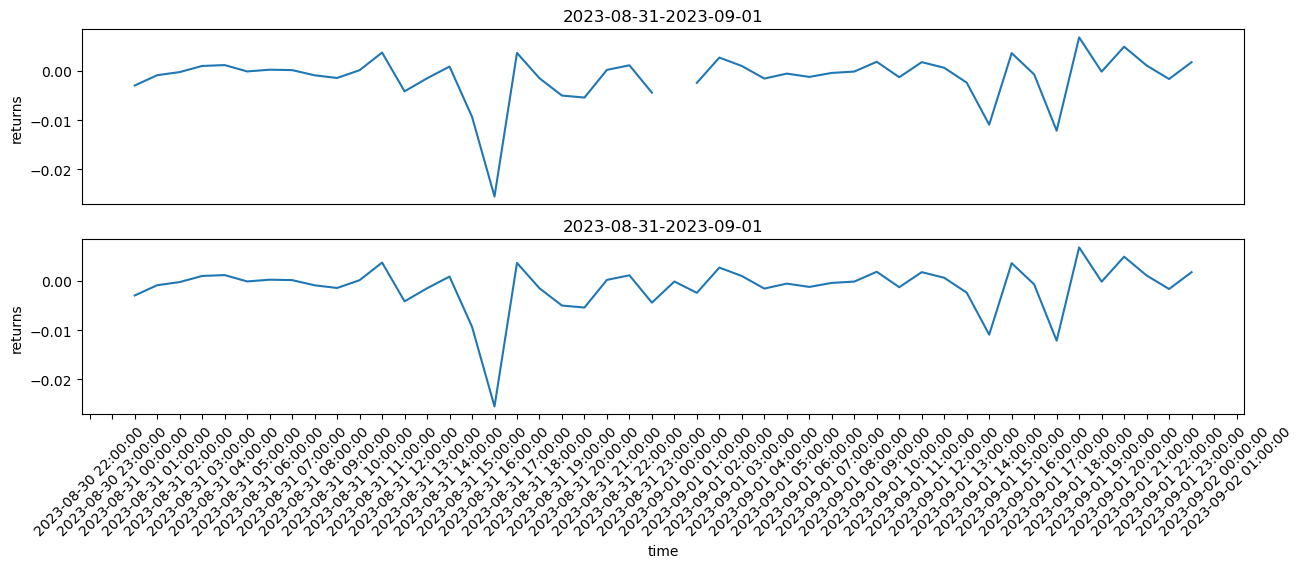

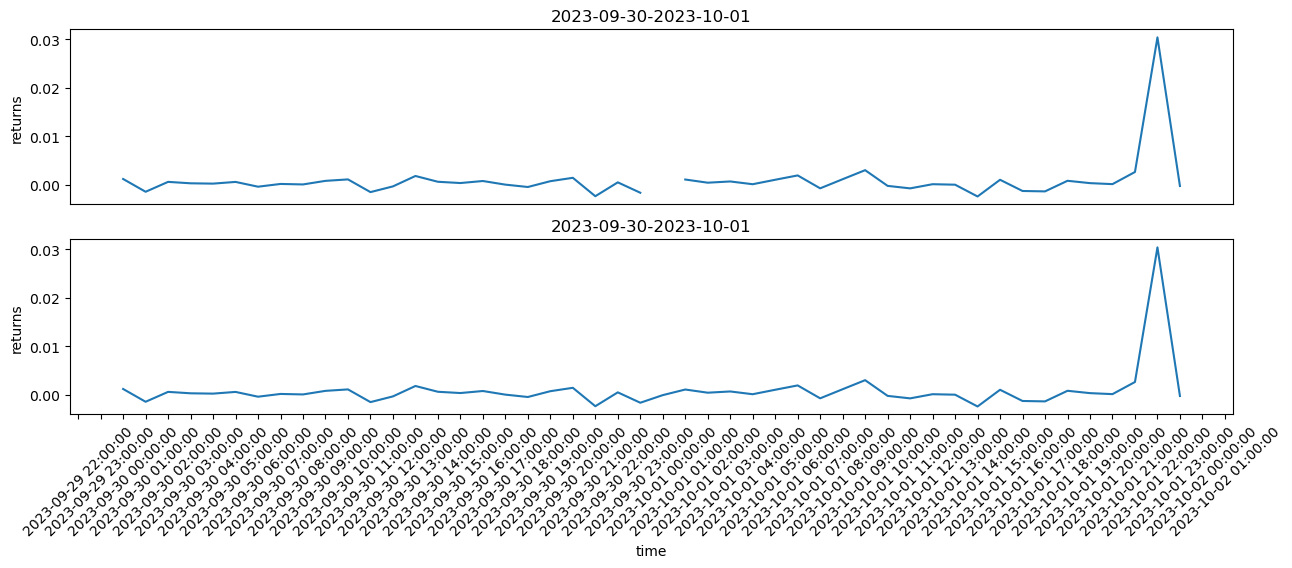

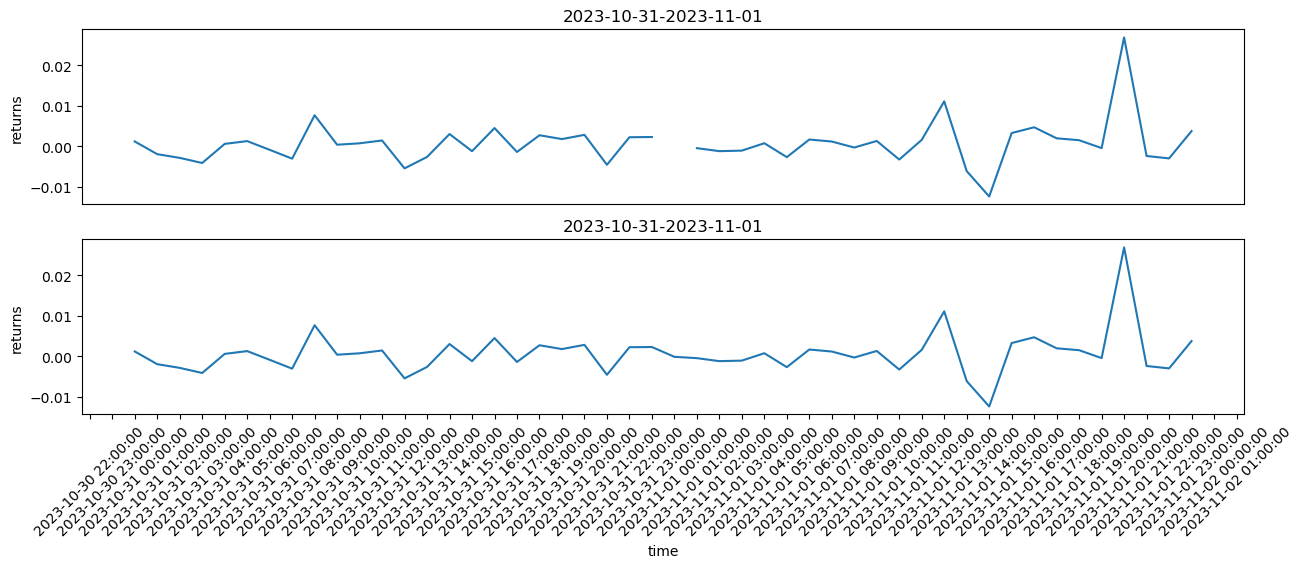

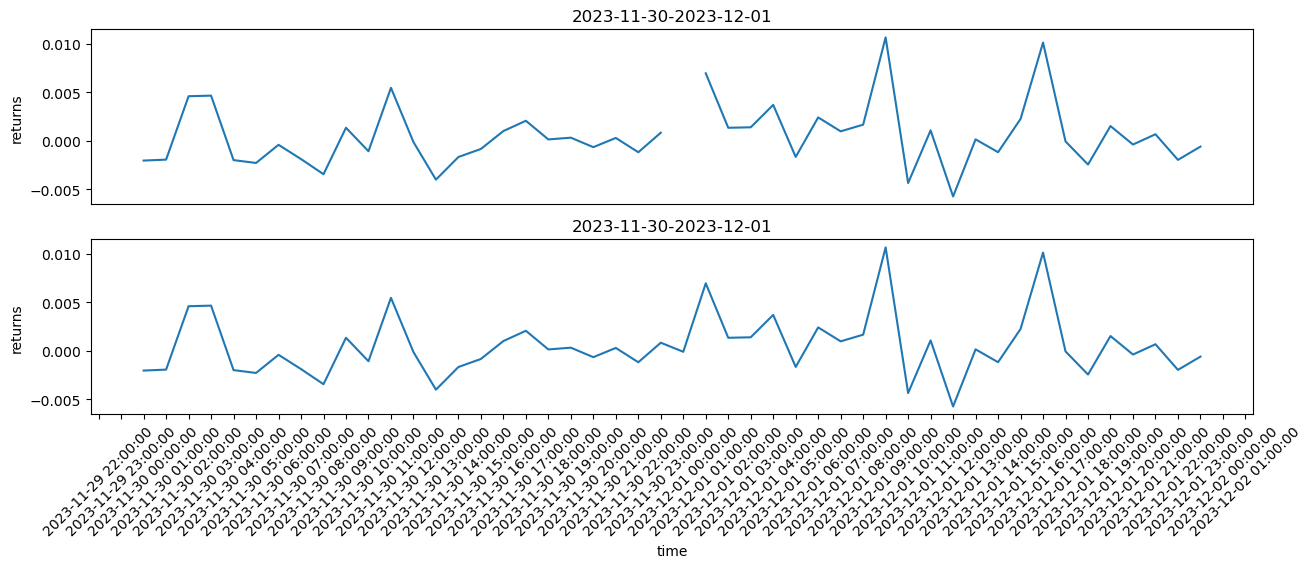

In [16]:
def Visualizing_returns(dfc, df, start_date, end_date, figsize=(15,5)):
    
    dfc_filtered = dfc.loc[start_date:end_date]
    df_filtered = df.loc[start_date:end_date]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    ax[0].plot(dfc_filtered.index, dfc_filtered)
    ax[0].set_ylabel('returns')
    ax[0].set_title(f'{start_date}-{end_date}')
    ax[0].set_xticks([])

    ax[1].plot(df_filtered.index, df_filtered)
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('returns')
    ax[1].set_title(f'{start_date}-{end_date}')
    
    ax[1].xaxis.set_major_locator(mdates.HourLocator())
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.show()
    
Visualizing_returns(dfc['returns'], df['returns'],'2023-01-31', '2023-02-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-02-28', '2023-03-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-03-31', '2023-04-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-04-30', '2023-05-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-05-31', '2023-06-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-06-30', '2023-07-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-07-31', '2023-08-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-08-31', '2023-09-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-09-30', '2023-10-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-10-31', '2023-11-01')
Visualizing_returns(dfc['returns'], df['returns'], '2023-11-30', '2023-12-01')

#### - volatility(interpolate_spline)

In [17]:
# spline_interpolate_column(df, 'volatility', order=3)

#### - volatility(AutoArima)

In [18]:
df_returns_v = df['volatility'].dropna()
autoarima_model = pm.auto_arima(df_returns_v, suppress_warnings=True)
print(autoarima_model)

 ARIMA(0,1,1)(0,0,0)[0]          


In [19]:
interpolate_arima(df['volatility'])

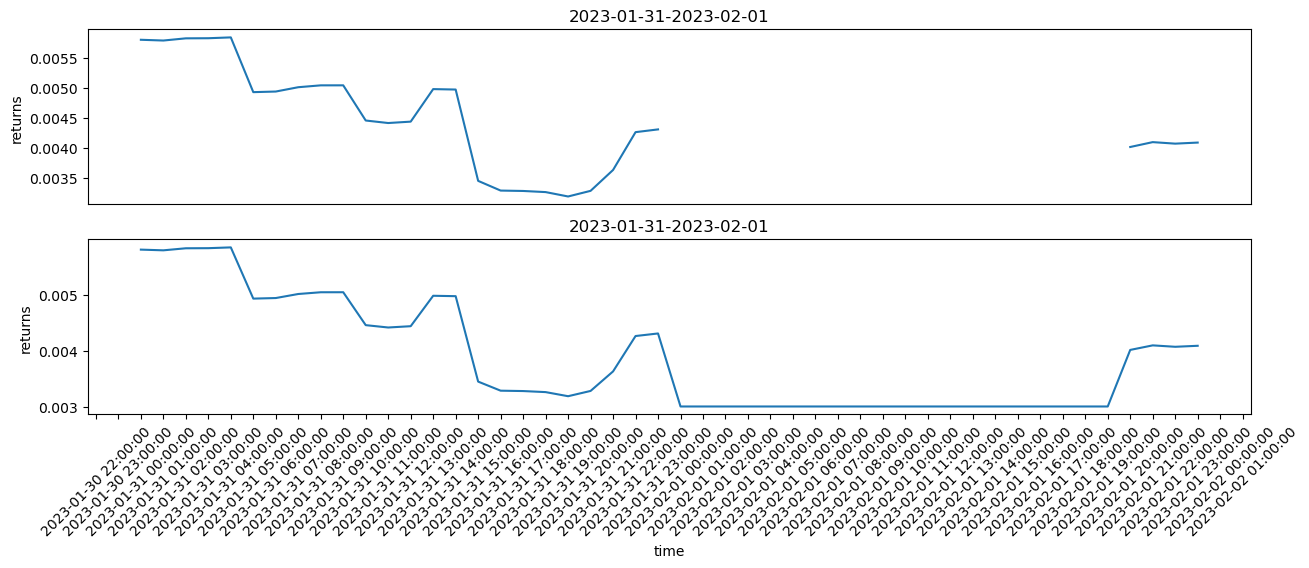

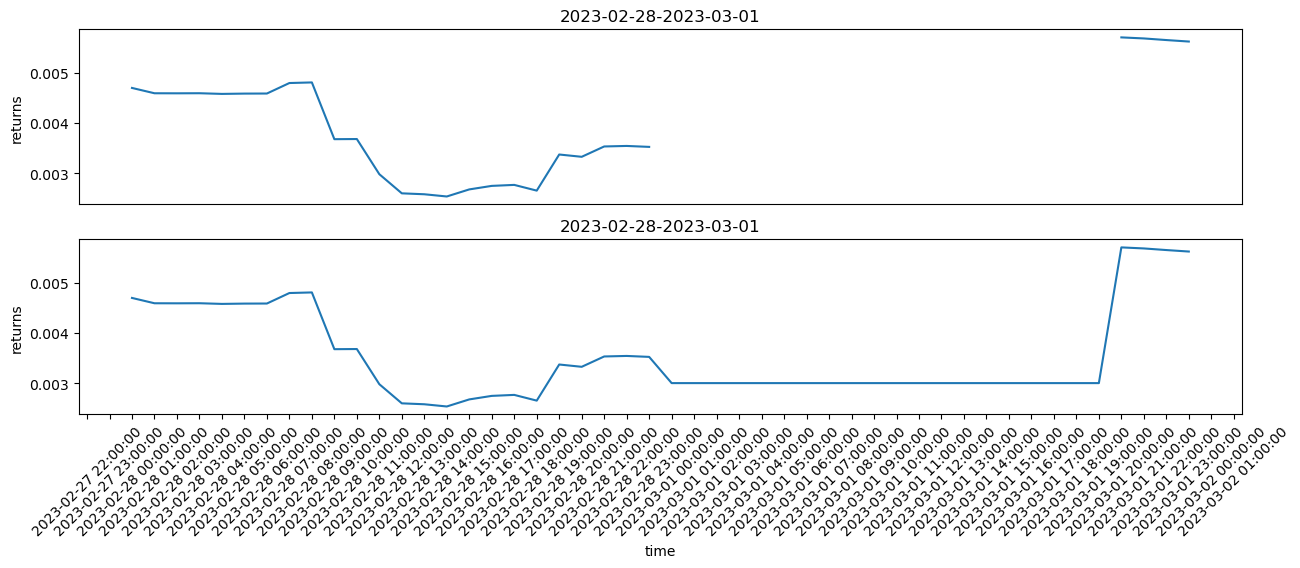

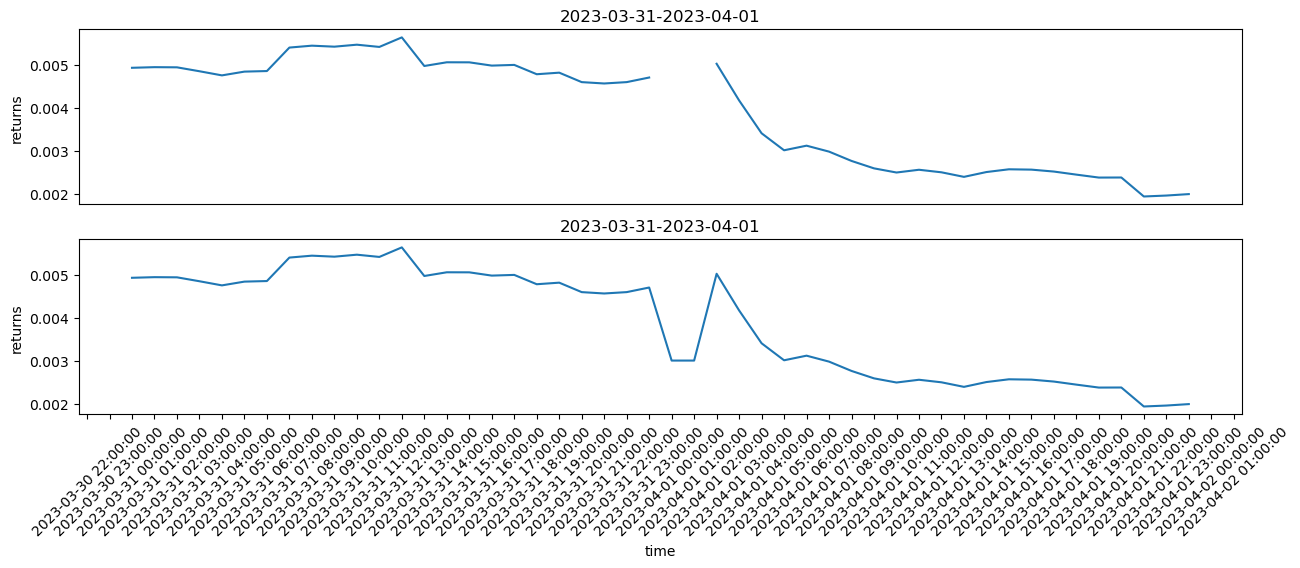

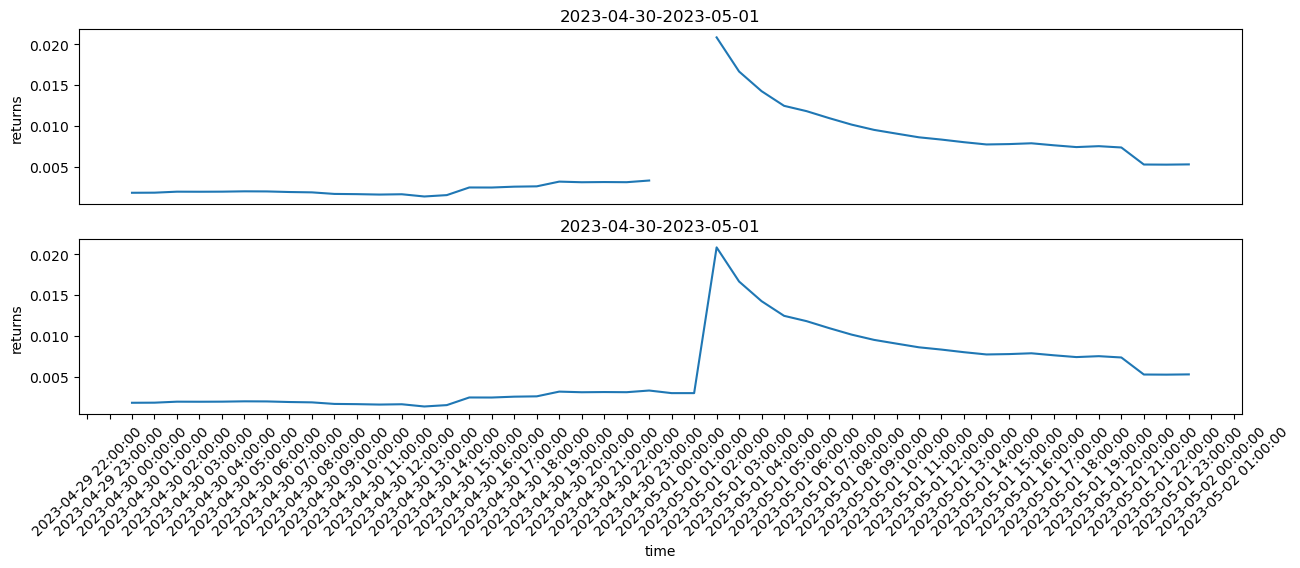

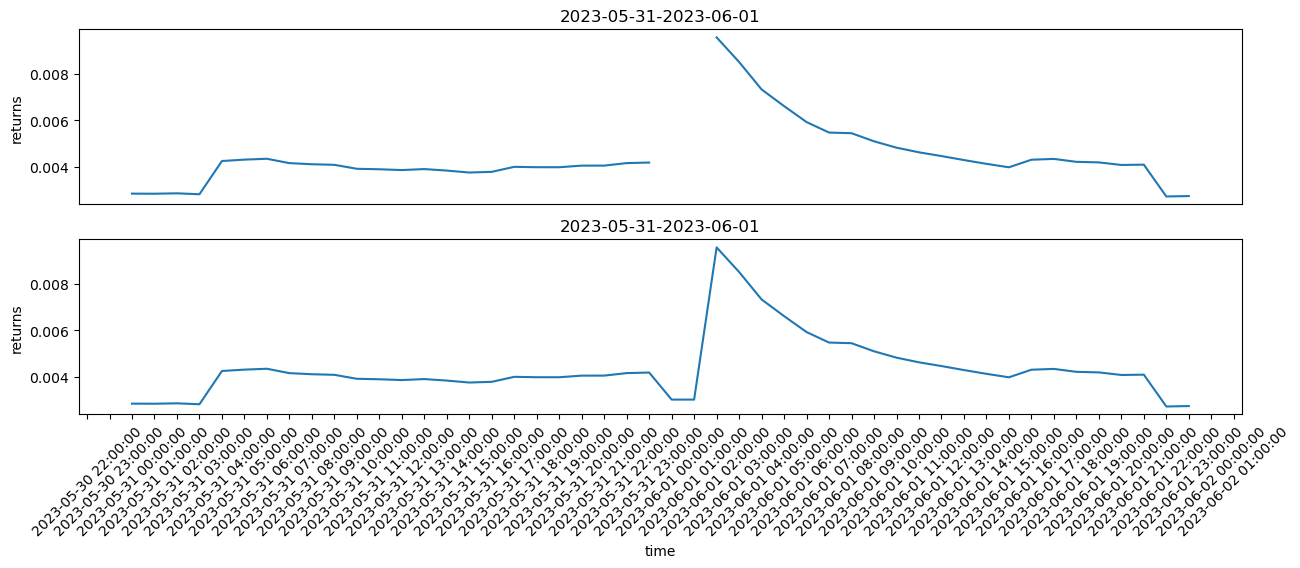

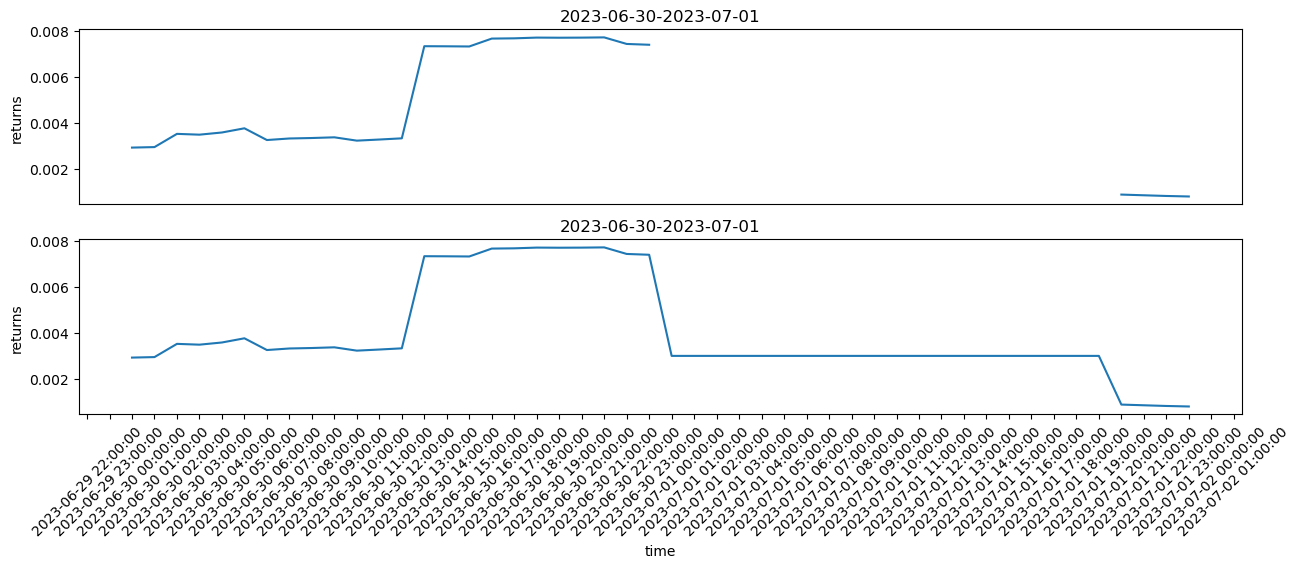

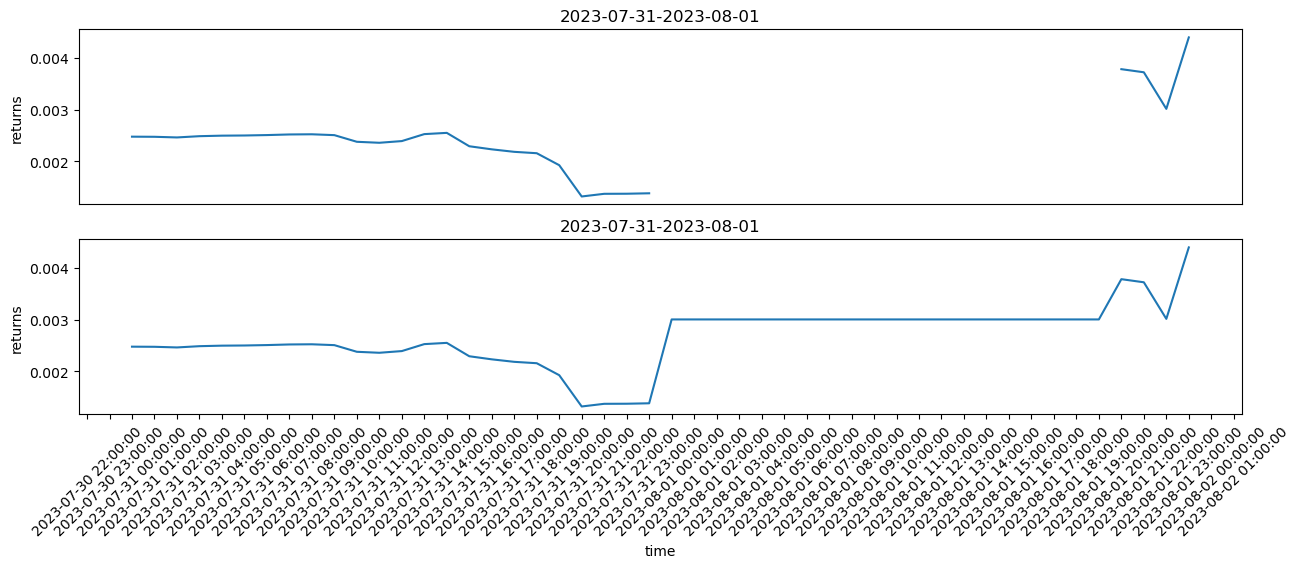

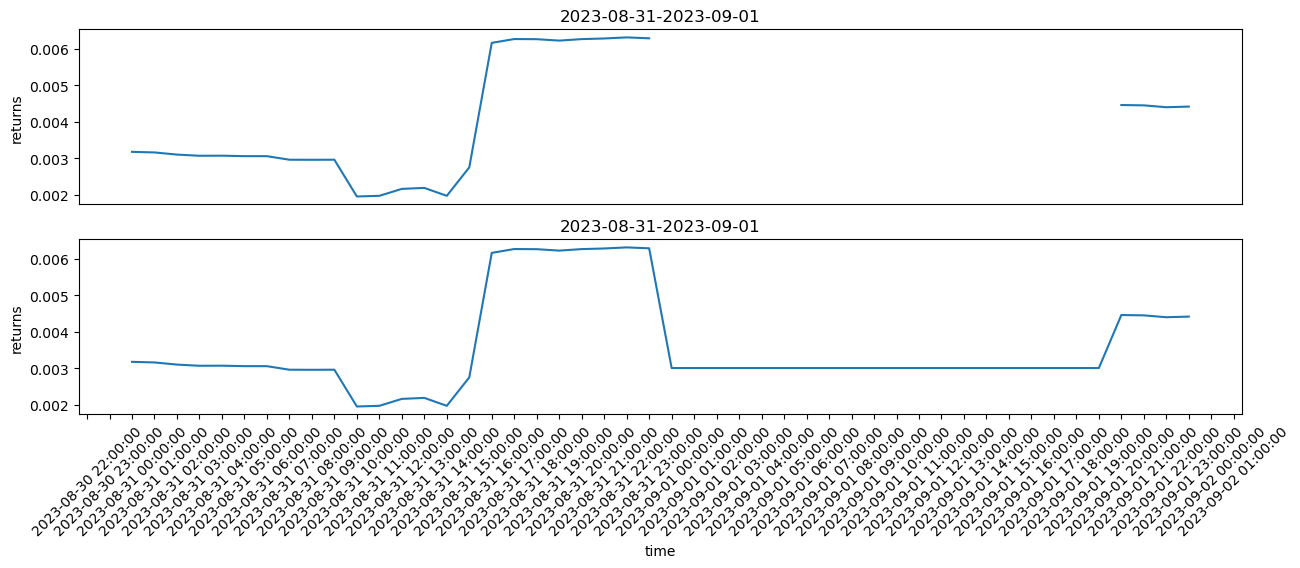

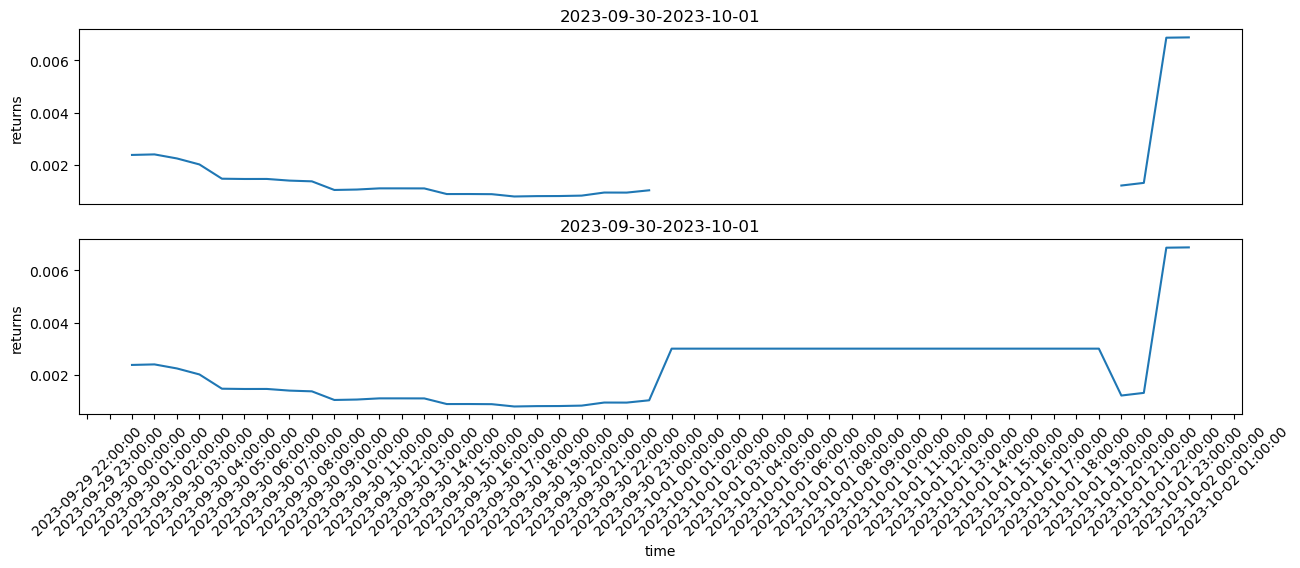

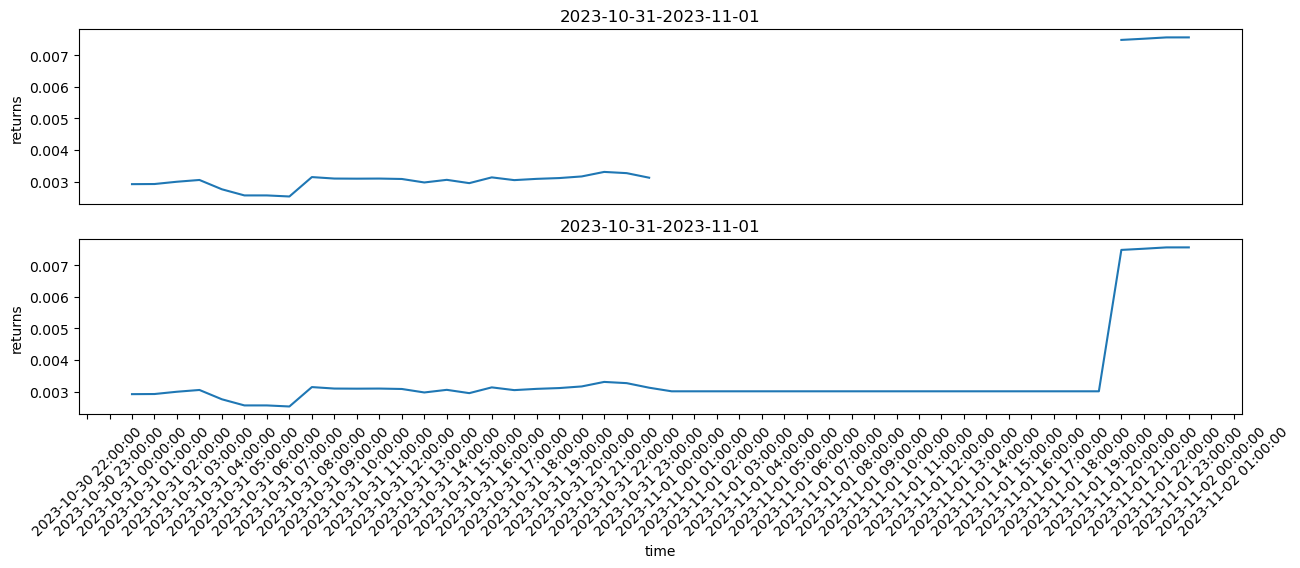

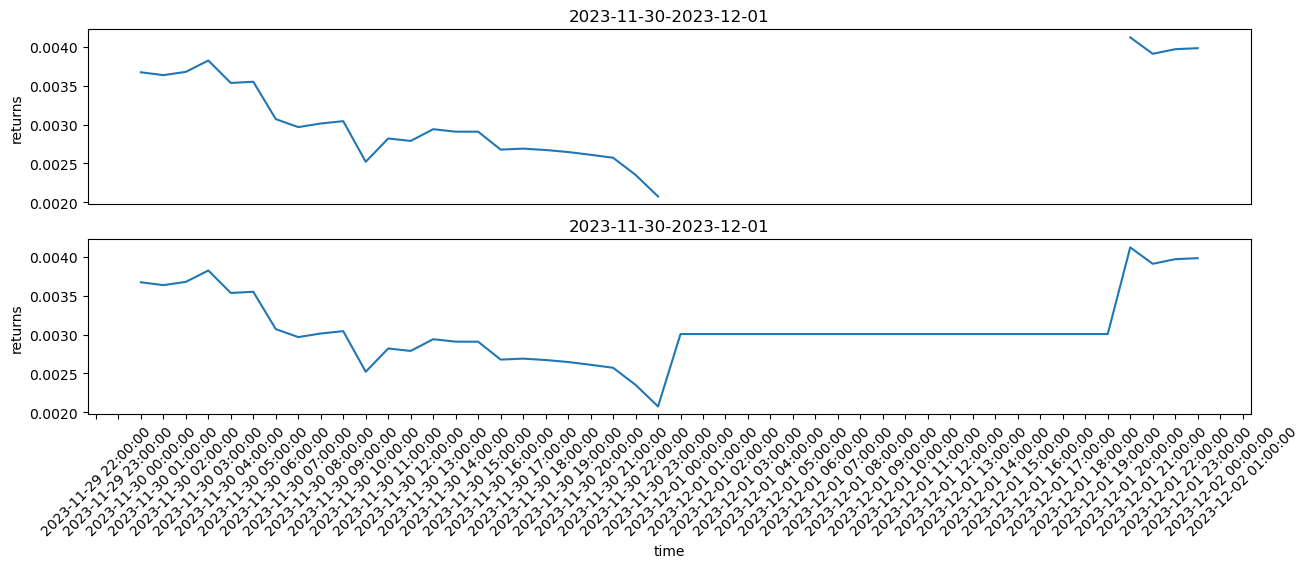

In [20]:
Visualizing_returns(dfc['volatility'], df['volatility'],'2023-01-31', '2023-02-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-02-28', '2023-03-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-03-31', '2023-04-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-04-30', '2023-05-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-05-31', '2023-06-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-06-30', '2023-07-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-07-31', '2023-08-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-08-31', '2023-09-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-09-30', '2023-10-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-10-31', '2023-11-01')
Visualizing_returns(dfc['volatility'], df['volatility'], '2023-11-30', '2023-12-01')

#### - volatility(GARCH)

In [21]:
#f[df['volatility'].isnull()].index # 매달 1일 20시간 결측(windows = 20)

In [22]:
# # 최적의 p,q 찾기 함수
# def interpolate_missing_values(df, column):
    
#     # 결측치 보간
#     returns = df[column]
#     interpolated_returns = returns.interpolate(method='linear')
#     df[column] = interpolated_returns

#     # 결측치 인덱스 추출
#     missing_indices = returns[returns.isna()].index

#     # 결측치 이전까지의 데이터 사용 - GARCH 모델 적합
#     model = arch.arch_model(returns.dropna(), vol='Garch', p=1, q=1)
#     model_fit = model.fit()

#     # 결측치 예측
#     forecasted_values = model_fit.forecast(start=missing_indices[0], horizon=len(missing_indices))

#     # 예측값 -> 결측치 위치에 대입해 보간
#     predicted_values = forecasted_values.mean.iloc[-1].values
#     returns.loc[missing_indices] = predicted_values

#     return df


# def find_optimal_pq(returns):
#     # 데이터 및 모델 정의
#     best_aic = float("inf")
#     best_bic = float("inf")
#     best_p = 0
#     best_q = 0
    
#     # p와 q의 후보값 설정
#     p_values = range(0, 5)  # p의 후보값 (0~4)
#     q_values = range(0, 5)  # q의 후보값 (0~4)

#     # 그리드 탐색
#     for p, q in itertools.product(p_values, q_values):
#         try:
#             model = arch.arch_model(returns, vol="Garch", p=p, q=q)
#             model_fit = model.fit(disp="off")
#             aic = model_fit.aic
#             bic = model_fit.bic
#             if aic < best_aic:
#                 best_aic = aic
#                 best_p = p
#                 best_q = q
#             if bic < best_bic:
#                 best_bic = bic
#                 best_p = p
#                 best_q = q
#         except:
#             continue

#     # 최적의 p와 q 값 출력
#     print("AIC를 기준으로 최적의 p와 q 값:", best_p, best_q)
#     print("BIC를 기준으로 최적의 p와 q 값:", best_p, best_q)
#     print('\n')
    
#     return best_p, best_q

# # GARCH 모델 생성 및 최적화 함수
# def simulate_garch_model(returns, p, q):
#     # GARCH 모델 생성 및 최적화
#     model = arch.arch_model(returns, vol='Garch', p=p, q=q)
#     model_fit = model.fit()

#     # 모델 시뮬레이션
#     nobs = len(returns)
#     simulated_data = model_fit.conditional_volatility[-nobs:] * np.random.normal(0, 1, nobs)

#     return simulated_data

In [23]:
# 'volatility' 컬럼의 결측치 보간
# df = interpolate_missing_values(df, 'volatility')

In [24]:
# best_p, best_q = find_optimal_pq(returns)
# simulated_data = simulate_garch_model(returns, best_p, best_q)
# print(simulated_data)

In [25]:
# Visualizing_returns(dfc['volatility'], df['volatility'],'2023-01-31', '2023-02-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-02-28', '2023-03-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-03-31', '2023-04-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-04-30', '2023-05-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-05-31', '2023-06-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-06-30', '2023-07-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-07-31', '2023-08-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-08-31', '2023-09-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-09-30', '2023-10-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-10-31', '2023-11-01')
# Visualizing_returns(dfc['volatility'], df['volatility'], '2023-11-30', '2023-12-01')

## 2. EDA

### 데이터 그래프 확인

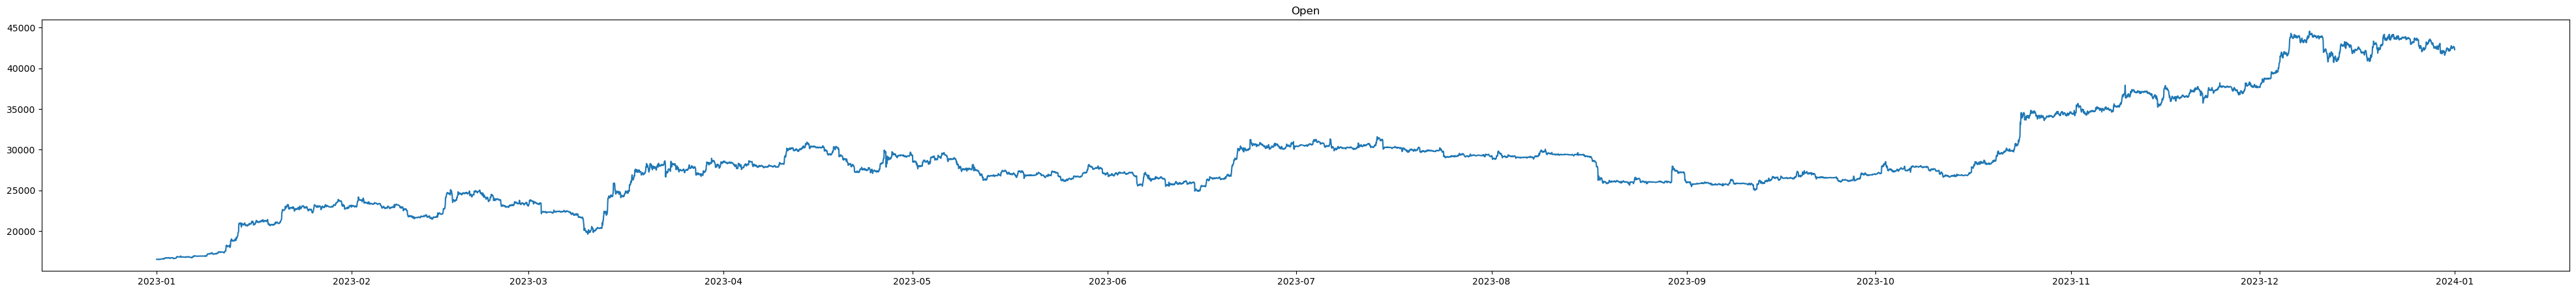

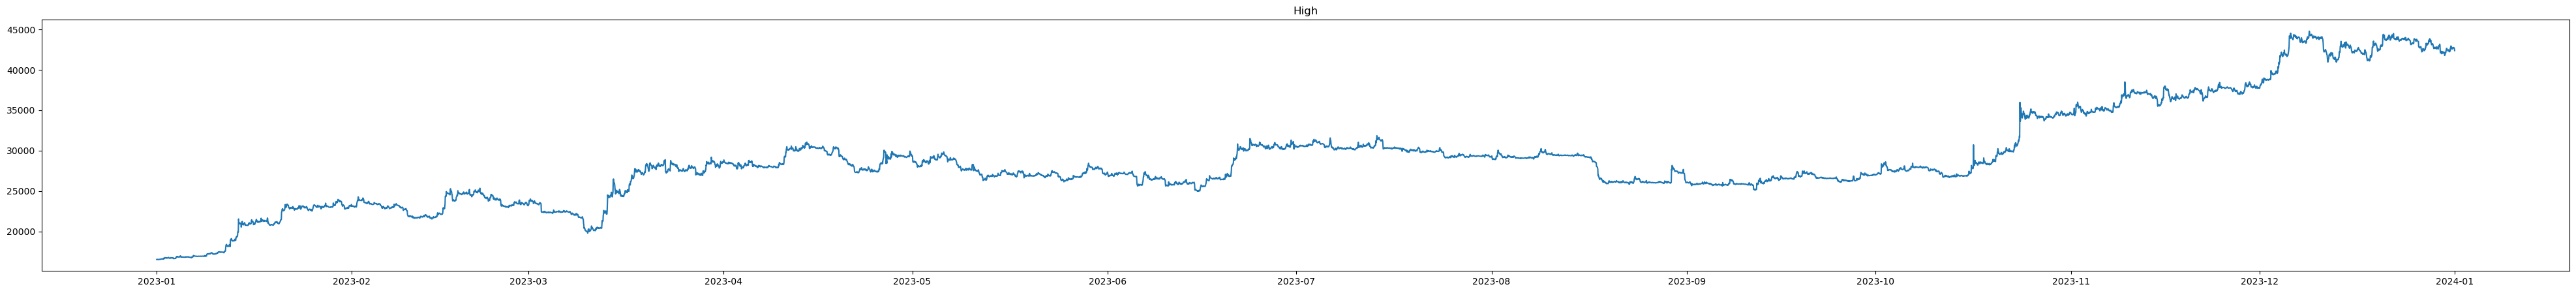

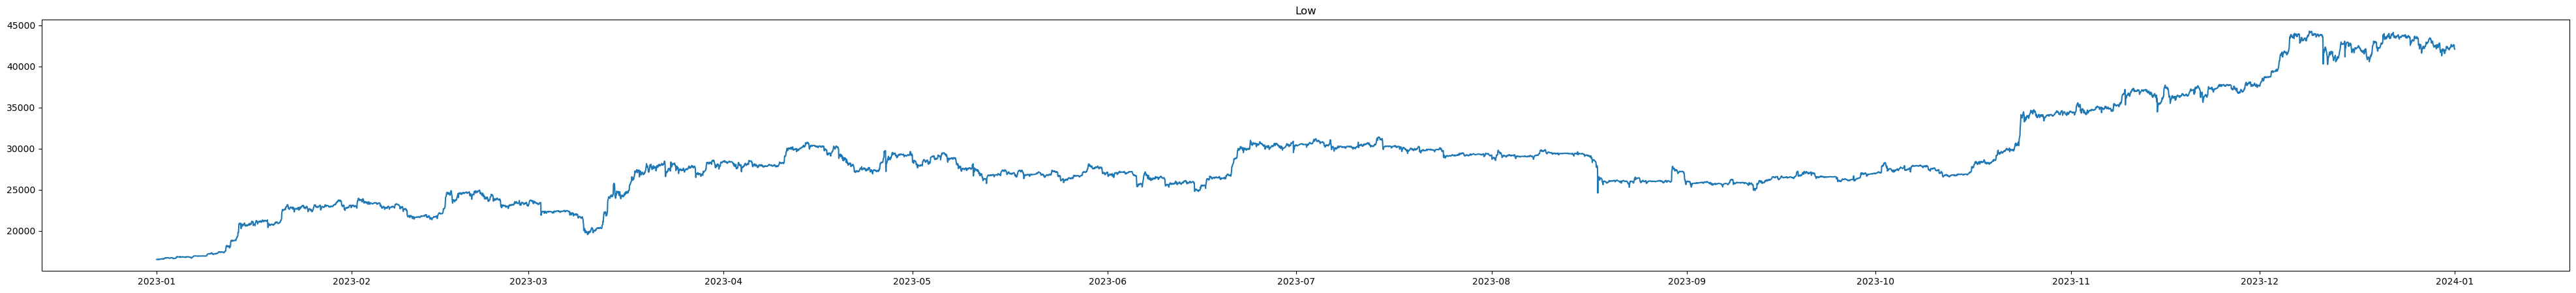

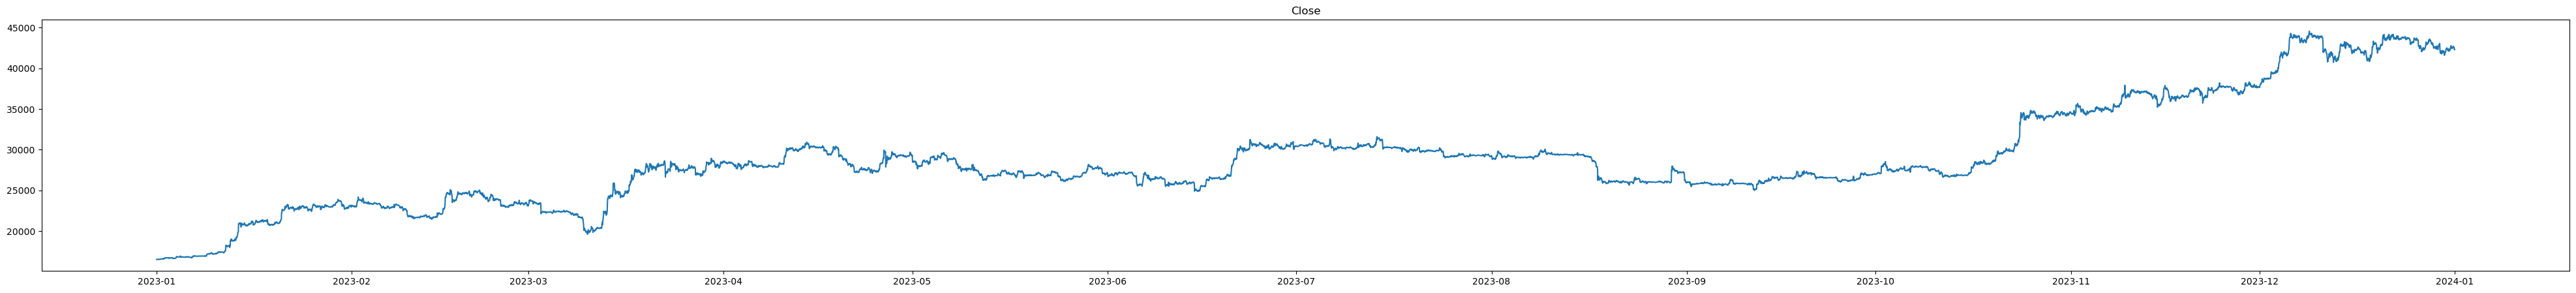

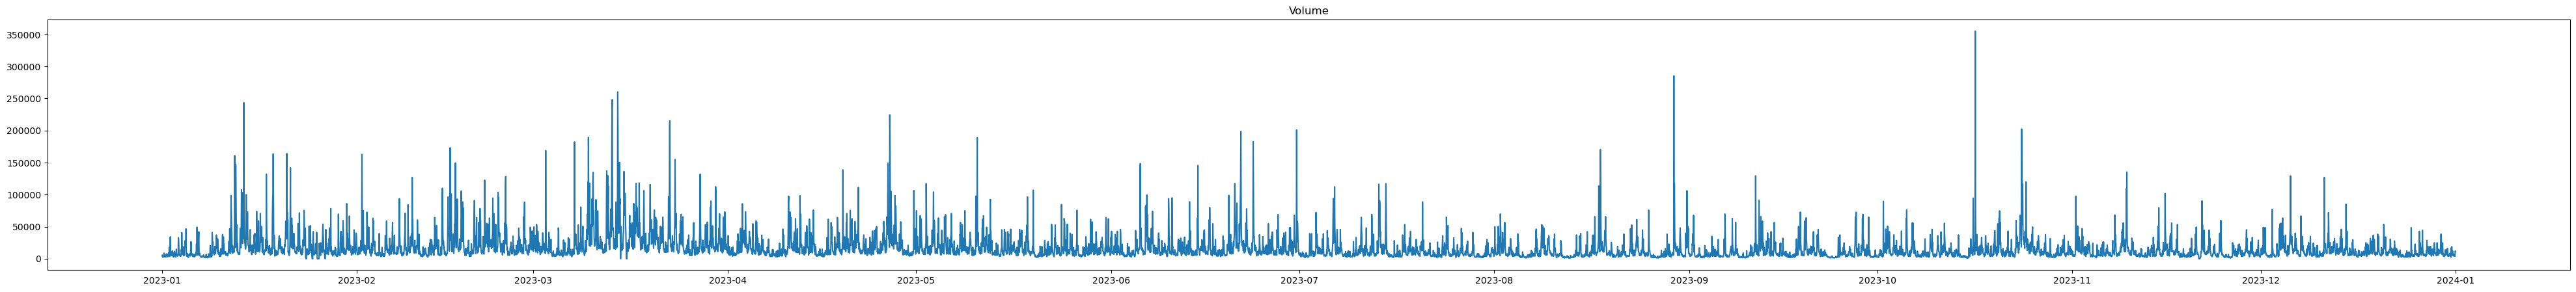

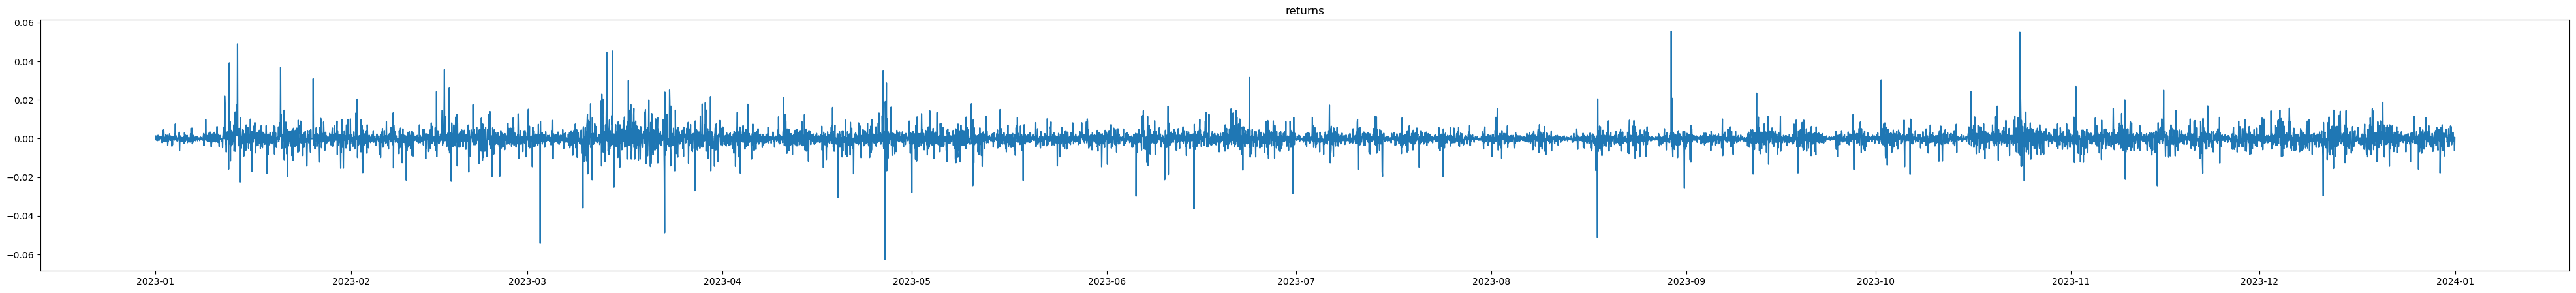

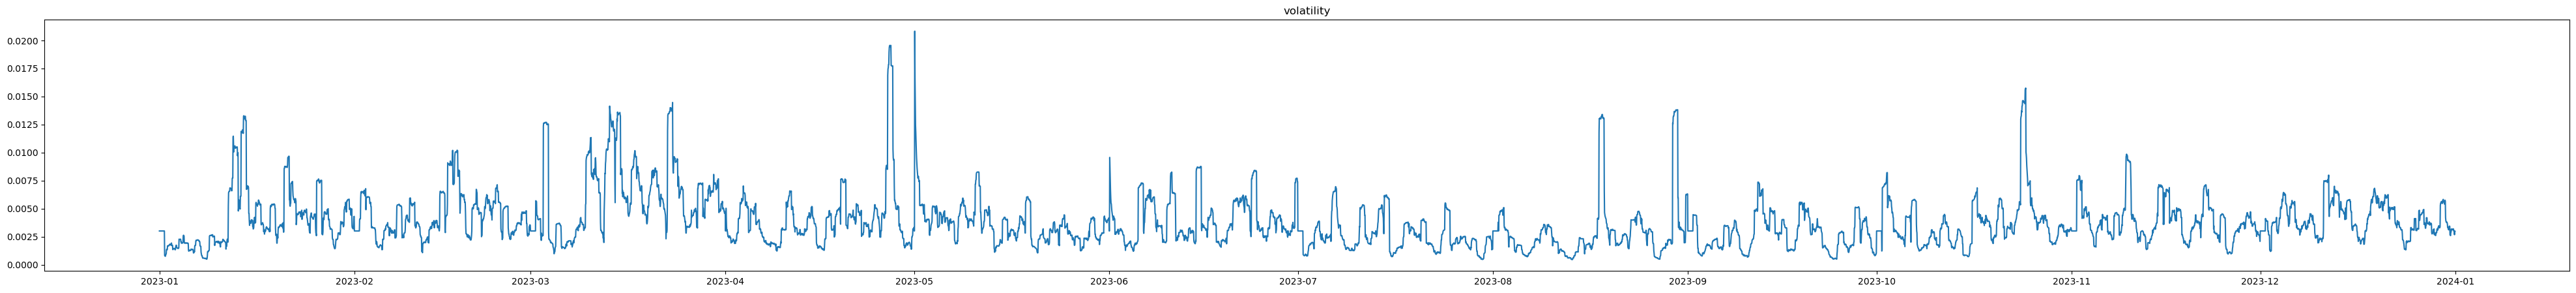

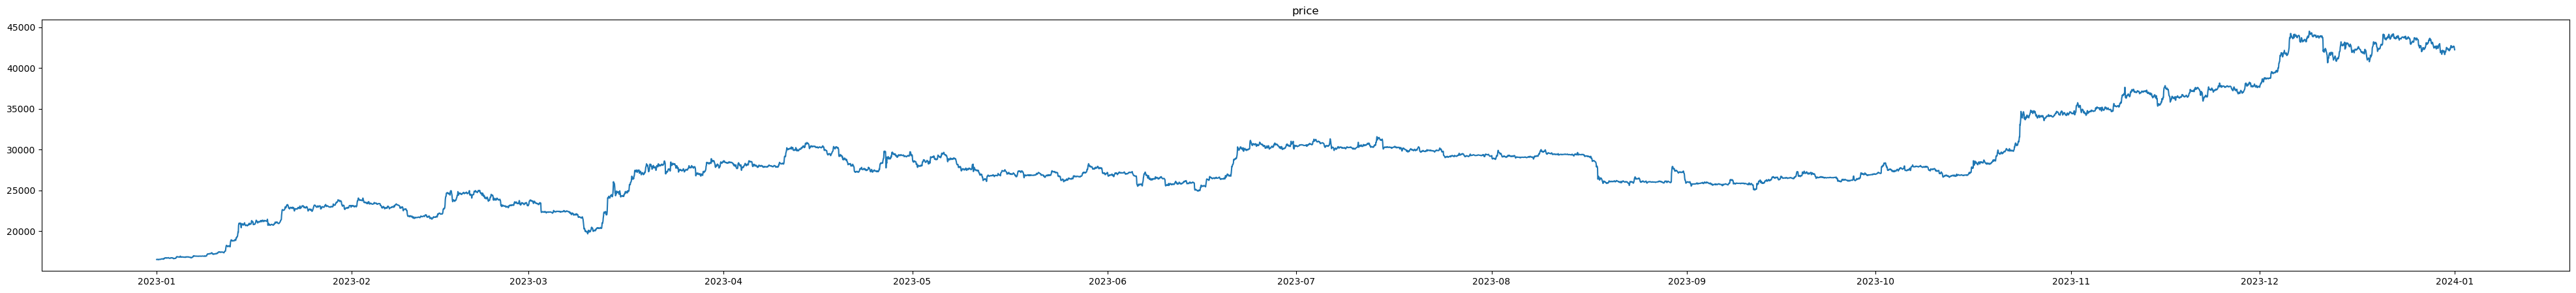

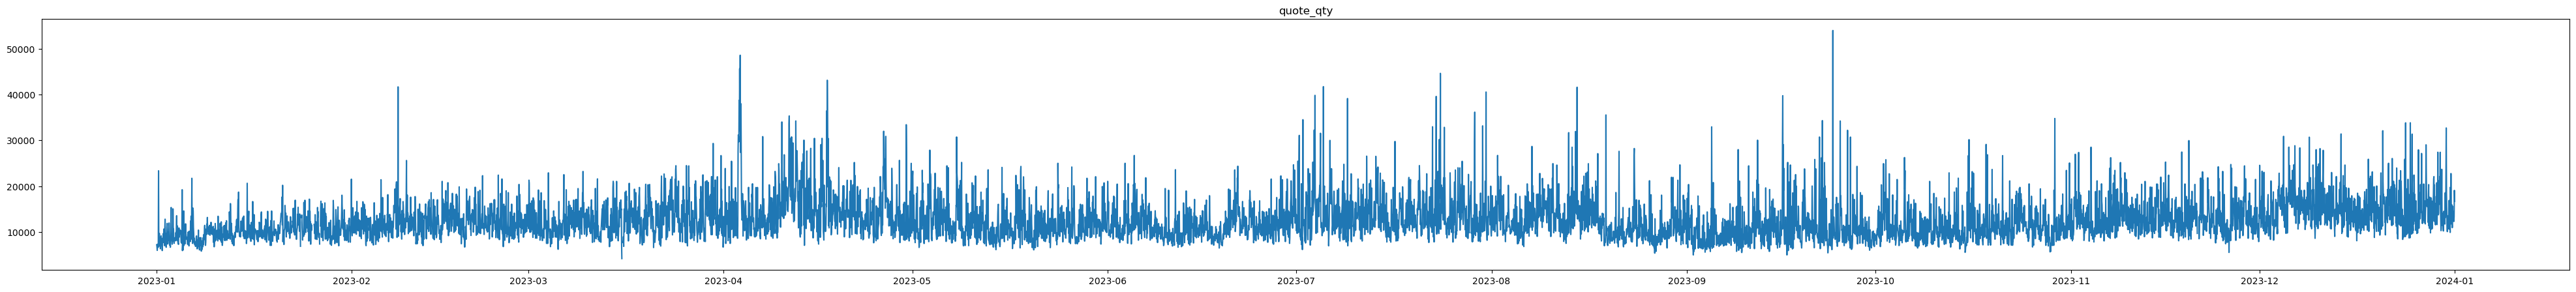

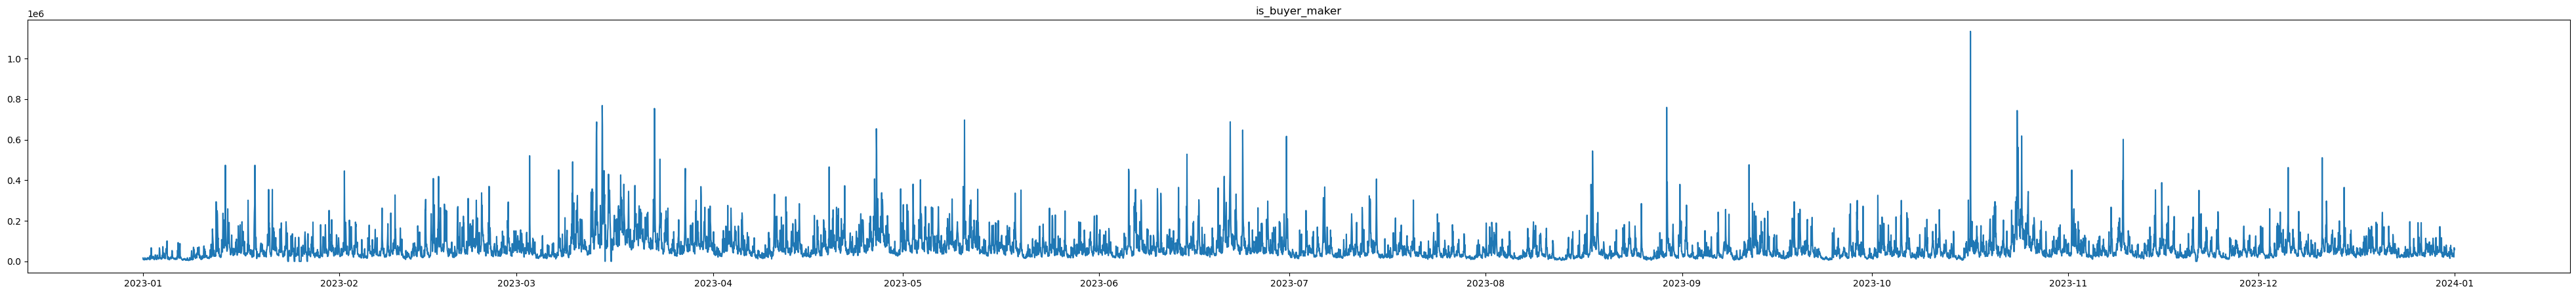

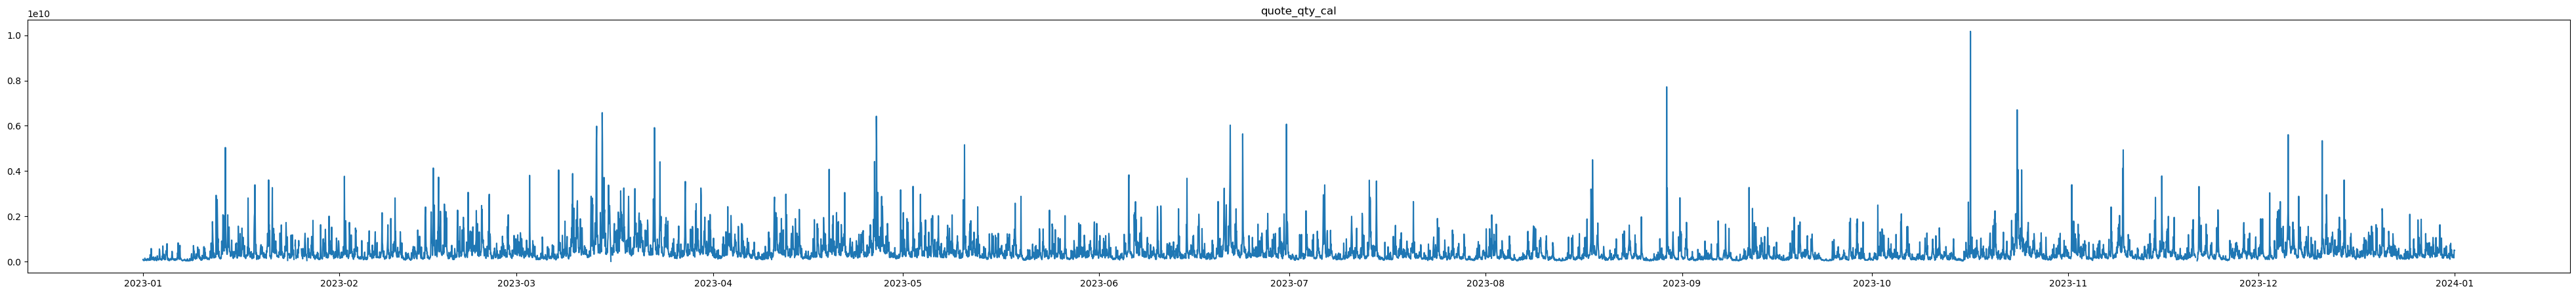

In [26]:
def Graph(data):
    for i, col in enumerate(data.columns):
        
        plt.figure(figsize=(50, 5))
        plt.plot(data.iloc[:,i])
        plt.title(f'{data.columns[i]}')
        
        # x축에 년도별 간격 표시
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        
Graph(df)

## Baseline Model

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rf_base(train_df, test_df, df_name=''): 
    # Train/Test Split
    X_train = train_df.drop('volatility', axis=1)
    y_train = train_df['volatility']
    
    X_test = test_df.drop('volatility', axis=1)
    y_test = test_df['volatility']

    # RandomForestRegressor
    rf_model = RandomForestRegressor(max_depth=15,
                                     max_features=0.2,
                                     n_estimators=400,
                                     random_state=42)  # random_state 추가

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측
    y_pred = rf_model.predict(X_test)

    # 평가지표(MAPE, RMSE)
    test_mape = calculate_mape(y_test, y_pred)
    test_rmse = calculate_rmse(y_test, y_pred)
    print(f'{df_name} : MAPE: {test_mape}, RMSE: {test_rmse}')

- Baseline Model test(테스트용)

In [29]:
df.isna().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
returns            0
volatility         0
price              0
quote_qty         24
is_buyer_maker     0
quote_qty_cal     24
dtype: int64

In [28]:
# df 모델링
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
rf_base(df_tr, df_te, 'df_tr')

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

- 손실 곡선

In [ ]:
def plot_loss_curve(df_train, df_test, df_name=''):
    # Extracting features and target variable
    X_train = df_train.drop('volatility', axis=1)
    y_train = df_train['volatility']
    
    X_test = df_test.drop('volatility', axis=1)
    y_test = df_test['volatility']

    # Varying n_estimators
    n_estimators_values = [50, 100, 150, 200, 400]
    mape_values = []
    rmse_values = []

    for n_estimators in n_estimators_values:
        # RandomForestRegressor
        rf_model = RandomForestRegressor(n_estimators=n_estimators)

        # 모델 학습
        rf_model.fit(X_train, y_train)

        # 예측
        y_pred = rf_model.predict(X_test)

        # 평가지표(MAPE, RMSE)
        test_mape = calculate_mape(y_test, y_pred)
        test_rmse = calculate_rmse(y_test, y_pred)
        
        mape_values.append(test_mape)
        rmse_values.append(test_rmse)

        print(f'{df_name} - n_estimators={n_estimators}: MAPE: {test_mape}, RMSE: {test_rmse}')

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    ax1.plot(n_estimators_values, mape_values, marker='o', label='MAPE')
    ax1.set_title(f'{df_name} - MAPE vs n_estimators')
    ax1.set_xlabel('n_estimators')
    ax1.set_ylabel('MAPE')
    ax1.legend()

    ax2.plot(n_estimators_values, rmse_values, marker='o', label='RMSE', color='orange')
    ax2.set_title(f'{df_name} - RMSE vs n_estimators')
    ax2.set_xlabel('n_estimators')
    ax2.set_ylabel('RMSE')
    ax2.legend()

    plt.show()


In [ ]:
# df_tr, df_te = train_test_split(df, test_size=0.2, random_state=42)
# plot_loss_curve(df_tr, df_te, 'df_tr')

n_estimators 값에 따라 평가지표 값에 유의한 차이가 없음

- grid_kfold

In [ ]:
def grid_search_rf(train_df, test_df, param,df_name='', cv=5):
    
    X_train, y_train = train_df.drop('volatility', axis=1), train_df['volatility']
    X_test, y_test = test_df.drop('volatility', axis=1), test_df['volatility']
    
    # 모델 정의
    rf_model = RandomForestRegressor()

    # 그리드 서치 객체 생성
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param, scoring='neg_mean_absolute_error', cv=KFold(n_splits=cv, shuffle=True, random_state=42))

    # 그리드 서치 수행
    grid_search.fit(X_train, y_train)

    # 최적의 하이퍼파라미터
    best_params = grid_search.best_params_
    print(f"Best Parameters: {best_params}")

    # 최적 모델 추출
    best_rf_model = grid_search.best_estimator_

    # 최적 모델로 예측
    y_pred = best_rf_model.predict(X_test)

    # 최적 모델 평가
    test_mape = calculate_mape(y_test, y_pred)
    test_rmse = calculate_rmse(y_test, y_pred)
    print(f'{df_name} MAPE: {test_mape}, RMSE: {test_rmse}')

    return best_rf_model


- 1차_하이퍼파라미터 튜닝_베이스라인 모델 파라미터 지정

In [33]:
# %time
# param = {
#     'n_estimators': [50, 100, 150, 200, 400],
#     'max_depth': [5, 10, 15, 20],
#     'max_features': [0.2, 0.4, 0.7, 0.8, 0.9, 1.0]
# }


# best_model = grid_search_rf(df_tr, df_te, param, df_name='df_tr')

### 2-1. Stationary
- 정상성 검정 > 차분 

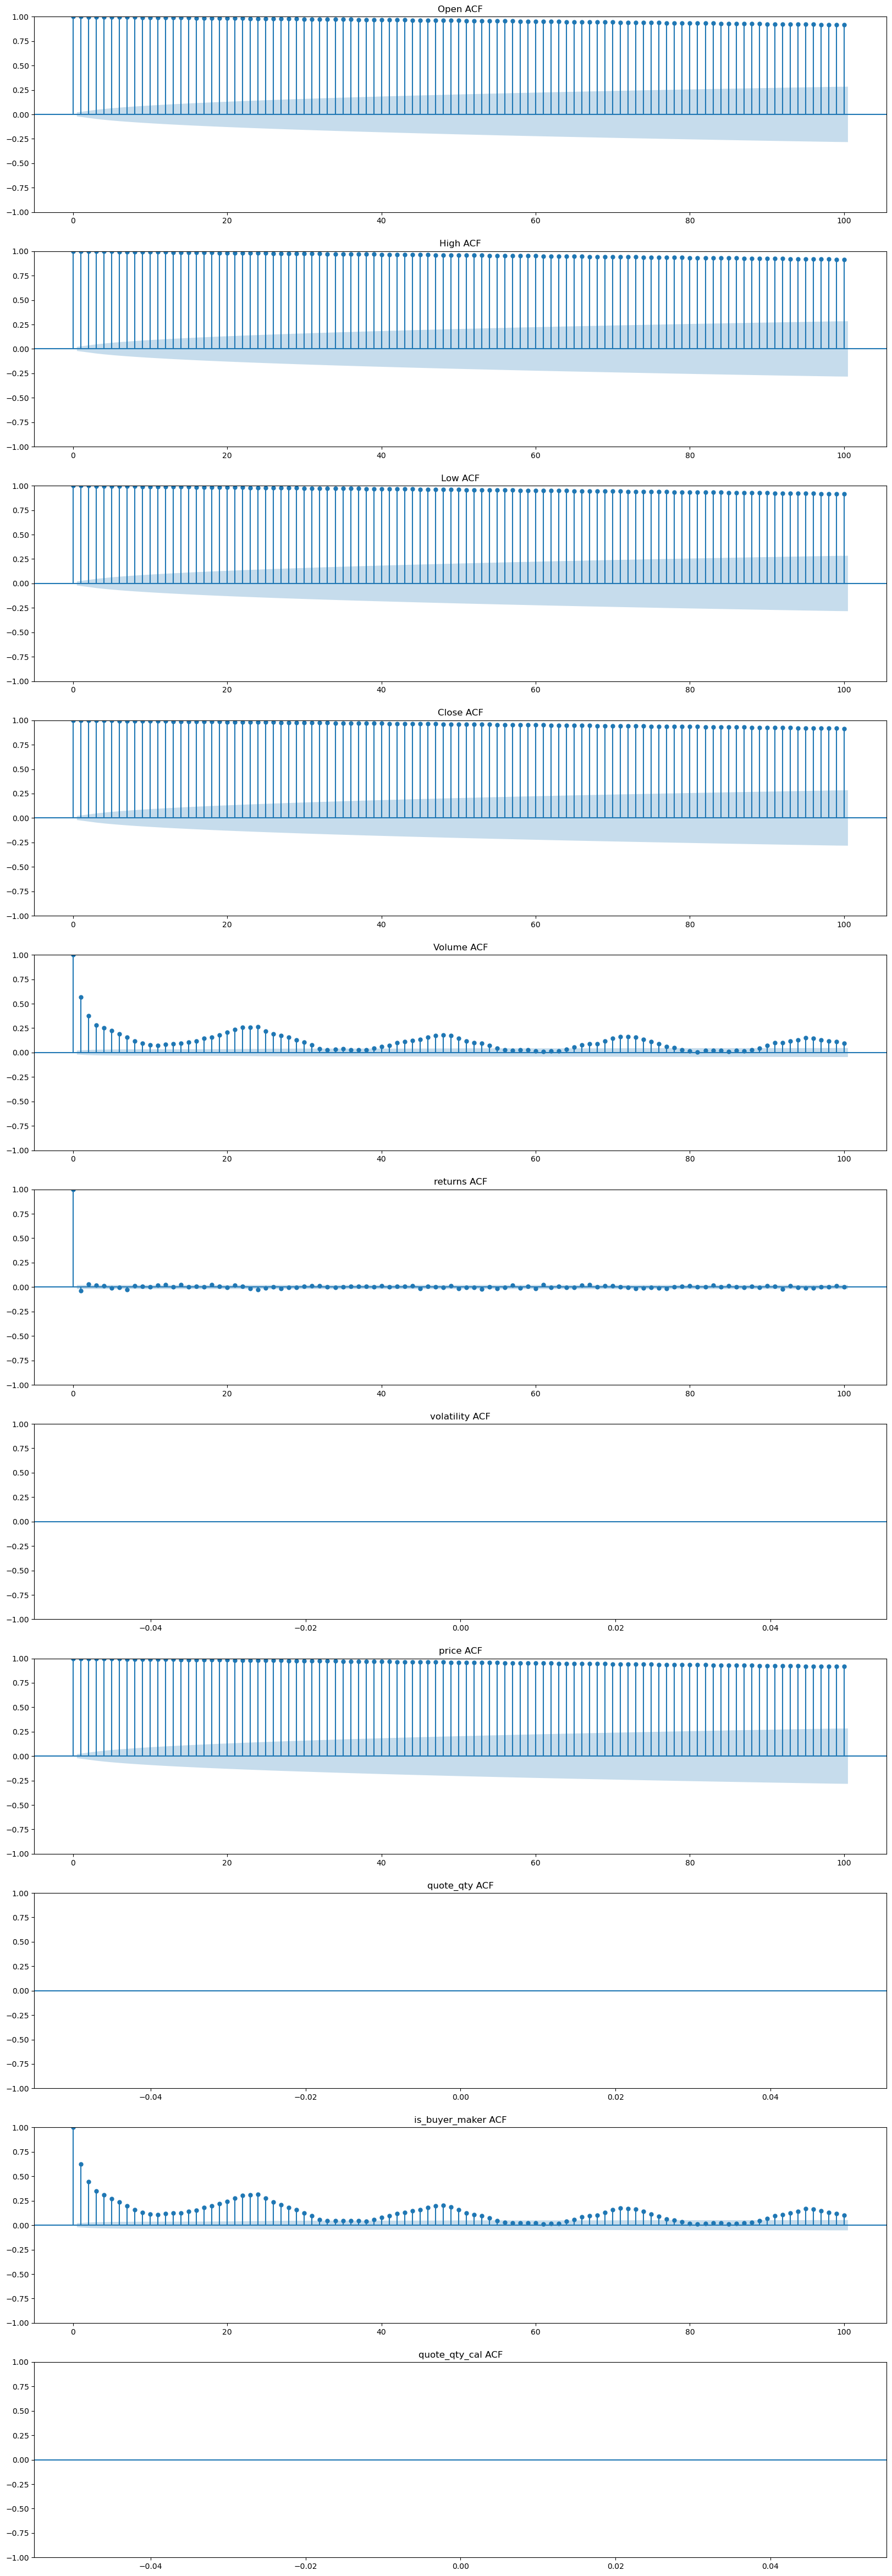

In [18]:
# ACF
def ACF(data):
    fig, ax = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(20,60))
    for i, col in enumerate(data.columns):
        sgt.plot_acf(data.iloc[:,i], lags = 100, ax=ax[i])
        ax[i].set_title(f"{data.columns[i]} ACF")
    plt.show
    
ACF(df)

In [27]:
# ADF
# H0: 단위근이 존재한다. H1: not H0
def ADF(data):
    for i in range(len(data.columns)):
        
        adf=adfuller(data.iloc[:,i])
        
        print(f'{data.columns[i]} : p-value: {adf[1]}', end=' ')
        if adf[1]<0.05: print('정상성 만족')
        else: print('X')
        
ADF(df)

Open : p-value: 0.8106252529657849 X
High : p-value: 0.7905055941037369 X
Low : p-value: 0.8040337346179989 X
Close : p-value: 0.810268525585239 X
Volume : p-value: 4.326885834545623e-17 정상성 만족
returns : p-value: 2.3655051393126445e-30 정상성 만족


MissingDataError: exog contains inf or nans

In [ ]:
# KPSS
# H0: 정상성을 만족한다. H1: not H0
def KPSS(data):
    for i in range(len(data.columns)):
        
        Kpss=kpss(data.iloc[:,i])
        
        print(f'{data.columns[i]} : p-value: {Kpss[1]}', end=' ')
        if Kpss[1]>0.05: print('정상성 만족')
        else: print('X')
        
KPSS(df)

In [ ]:
# 차분
def DIFF(data):
    for i in range(len(data.columns)):
        
        #차분
        diff=data.diff().dropna()
        
        # ADF
        adf=adfuller(diff.iloc[:,i])
        # KPSS
        Kpss=kpss(diff.iloc[:,i])
        
        print(f'-------------- {data.columns[i]} --------------')
        print('ADF', end=' ')
        print(f'p-value: {adf[1]}', end=' ')
        if adf[1]<0.05: print('정상성 만족')
        else: print('X')
        print('KPSS', end=' ')       
        print(f'p-value: {Kpss[1]}', end=' ')
        if Kpss[1]>0.05: print('정상성 만족')
        else: print('X')
            
    return diff
            
df_diff=DIFF(df)

In [ ]:
# 로그변환
def LOG(data):
    for i in range(len(data.columns)):
        
        #차분
        log=np.log1p(data)
        
        # ADF
        adf=adfuller(log.iloc[:,i])
        # KPSS
        Kpss=kpss(log.iloc[:,i])
        
        print(f'-------------- {data.columns[i]} --------------')
        print('ADF', end=' ')
        print(f'p-value: {adf[1]}', end=' ')
        if adf[1]<0.05: print('정상성 만족')
        else: print('X')
        print('KPSS', end=' ')       
        print(f'p-value: {Kpss[1]}', end=' ')
        if Kpss[1]>0.05: print('정상성 만족')
        else: print('X')
            
    return log
            
df_log=LOG(df)

In [ ]:
# diff data Modeling
df_diff_tr, df_diff_te = train_test_split(df_diff, test_size=0.2, random_state=42)
rf_base(df_diff_tr, df_diff_te, 'df_diff_tr')

In [ ]:
# log data Modeling
df_log_tr, df_log_te = train_test_split(df_log, test_size=0.2, random_state=42)
rf_base(df_log_tr, df_log_te, 'df_log_tr')

## 2-2. Technical Indicators

#### MACD Function (Moving Average Convergence Divergence)
Calculates the difference between short-term and long-term moving averages to indicate trends.
Quickly detects trends but may be sensitive to noise.
#### Stochastic Oscillator Function
An indicator that reflects the trend of price fluctuations in financial markets such as stocks.
Calculates the relative strength of the price based on the highest (High) and lowest (Low) prices over the last N days.
#### ATR Function (Average True Range)
An indicator that represents the average range of price movements.
Calculates volatility using True Range.
#### Bollinger Bands Function
An indicator that uses moving averages and standard deviation to assess the relative height of prices.
Forms upper and lower bands around the moving average, indicating deviations in stock prices.
#### ROC Function (Rate of Change)
Measures the relative price change over a certain period.
Analyzes the flow of stock prices by comparing the current price with the price a certain period ago.
#### RSI Function (Relative Strength Index)
Relative Strength Index indicating the relative strength of price movements over a specific period.
Generally, values above 70 indicate an uptrend, while values below 30 indicate a downtrend.
#### Ultimate Oscillator Function
A comprehensive indicator that combines relative strength for various periods.
Provides a richer analysis of the stock price trend.

In [ ]:
# MACD 함수
def MACD(df, short_window, long_window, signal_window):
    
    df[f'Short_MA_{short_window}'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df[f'Long_MA_{long_window}'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df[f'MACD_{short_window}{long_window}'] = df[f'Short_MA_{short_window}'] - df[f'Long_MA_{long_window}']
    df[f'Signal_Line_{signal_window}'] = df[f'MACD_{short_window}{long_window}'].ewm(span=signal_window, adjust=False).mean()
    df[f'MACD_Oscillator_{short_window}{long_window}'] = df[f'MACD_{short_window}{long_window}'] - df[f'Signal_Line_{signal_window}']
    
    return df
    
    
# Stochastic Oscillator 함수
def cal_stoc_os(df, period, m):
    
    # 최근 N일간의 최고가(H)와 최저가(L)
    df[f'SO high_{period}{m}'] = df['High'].rolling(window=period).max()
    df[f'SO low_{period}{m}'] = df['Low'].rolling(window=period).min()
    
    # %K 계산
    df[f'SO %K_{period}{m}'] = (df['Close'] - df[f'SO low_{period}{m}']) / (df[f'SO high_{period}{m}'] - df[f'SO low_{period}{m}']) * 100
    
    # %D 계산
    df[f'SO %D_{period}{m}'] = df[f'SO %K_{period}{m}'].rolling(m).mean()
    
    return df
    
    
# ATR 함수
def calculate_atr(df, period):
    # True Range 계산
    df['high-low'] = df['High'] - df['Low']
    df['high-close'] = abs(df['High'] - df['Close'].shift())
    df['low-close'] = abs(df['Low'] - df['Close'].shift())
    
    df['true_range'] = df[['high-low', 'high-close', 'low-close']].max(axis=1)
    
    # ATR 계산
    df[f'atr_{period}'] = df['true_range'].rolling(window=period, min_periods=1).mean()
    
    # 임시 열 삭제
    df.drop(['high-low', 'high-close', 'low-close', 'true_range'], axis=1, inplace=True)
    
    return df


# Bollinger_band 함수
def bollinger_bands(df, window, num_std_dev):
    
    # 이동평균 계산
    df['rolling_mean'] = df['price'].rolling(window=window).mean()

    # 표준편차 계산
    df['rolling_std'] = df['price'].rolling(window=window).std()

    # 볼린저 밴드 상단 및 하단 계산
    df[f'upper_band_{window}'] = df['rolling_mean'] + (num_std_dev * df['rolling_std'])
    df[f'lower_band_{window}'] = df['rolling_mean'] - (num_std_dev * df['rolling_std'])

    # 필요없는 컬럼 삭제
    df.drop(['rolling_mean', 'rolling_std'], axis=1, inplace=True)

    return df


# ROC 계산 함수
def calculate_roc(df, close_column, timeperiod):
    prev_close = df[close_column].shift(timeperiod)
    df[f'roc_{timeperiod}'] = ((df[close_column] - prev_close) / prev_close) * 100
    
    return df


# RSI 계산 함수
def calculate_rsi(df, close_column, timeperiod):
    delta = df[close_column].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=timeperiod, min_periods=1).mean()
    avg_loss = loss.rolling(window=timeperiod, min_periods=1).mean()

    rs = avg_gain / avg_loss
    df[f'rsi_{timeperiod}'] = 100 - (100 / (1 + rs))
    
    return df


# Ultimate Oscillator 함수
def calculate_uo(df, period1, period2, period3):
    # True Range 계산
    df['true_range'] = df['High'].combine(df['Close'].shift(1), max) - df['Low'].combine(df['Close'].shift(1), min)
    
    # Average True Range (ATR) 계산
    df['avg_true_range1'] = df['true_range'].rolling(window=period1, min_periods=1).mean()
    df['avg_true_range2'] = df['true_range'].rolling(window=period2, min_periods=1).mean()
    df['avg_true_range3'] = df['true_range'].rolling(window=period3, min_periods=1).mean()

    # Buying Pressure 계산
    df['buying_pressure'] = df['Close'] - df[['Open', 'Close']].min(axis=1)

    # True Buying Pressure (TBP) 계산
    df['true_buying_pressure1'] = df['buying_pressure'].rolling(window=period1, min_periods=1).sum()
    df['true_buying_pressure2'] = df['buying_pressure'].rolling(window=period2, min_periods=1).sum()
    df['true_buying_pressure3'] = df['buying_pressure'].rolling(window=period3, min_periods=1).sum()

    # UO 계산
    df[f'UO_{period1}{period2}{period3}'] = (
        100
        * (4 * df['true_buying_pressure1'] / df['avg_true_range1'])
        + 2 * (4 * df['true_buying_pressure2'] / df['avg_true_range2'])
        + (df['true_buying_pressure3'] / df['avg_true_range3'])
    ) / (4 + 2 + 1)

    # 필요 없는 열 제거
    df = df.drop(['true_range', 'avg_true_range1', 'avg_true_range2', 'avg_true_range3',
                  'buying_pressure', 'true_buying_pressure1', 'true_buying_pressure2', 'true_buying_pressure3'], axis=1)

    return df

### Technical Indicators - Optimization

1. 결측치
2. 평가지표 비교
* 수익률: 볼린저 밴드를 기반으로 한 수익률을 평가하는 지표로, 해당 지표가 가격의 특이값을 얼마나 잘 캐치하고 이에 따른 수익을 얼마나 창출하는지를 측정.
* 변동성: 볼린저 밴드를 기반으로 주가의 변동성을 얼마나 잘 포착하는지를 확인하는 지표
* 최대 손실: 볼린저 밴드를 기반으로 투자 전략이 어떤 상황에서 최대 손실을 겪는지 확인하는 지표
* 승률: 볼린저 밴드의 신호가 실제로 가격의 특이값을 잘 나타내고 있는지 확인하는 지표로, 해당 기준은 상한선('upper_band')를 넘는 경우를 '승리'로 간주.

##### Stochastic Oscillator
일반적으로는 14와 3을 사용한다. 
- period의 경우, 주가 데이터의 기간에 따라 최적의 값을 설정할 수 있다. 예를 들어, 10일, 30일, 50일 등 다양한 기간을 선택할 수 있다.
- m은 %K의 이동평균을 계산하는데 사용되는 기간이다. 따라서, 2, 5, 10 등 다른 값을 설정할 수도 있다.
> 주가 데이터의 특성과 분석 목적에 따라 period와 m의 값을 조정하여 최적의 결과를 얻을 수 있다

In [ ]:
# 평가 지표를 저장 딕셔너리
evaluation_results = {}

# period와 m의 다양한 조합 설정
periods = [14, 20, 30]  # 다양한 period
ms = [2, 3, 5, 10]  # 다양한 m

# 각 조합 평가 지표 계산
for period in periods:
    for m in ms:
        df_copy = df.copy()
        df_copy = cal_stoc_os(df_copy, period=period, m=m)
        
        # 평가 지표 계산 (수익률, 변동성, 최대 손실, 승률)
        returns = df_copy['Close'].pct_change().cumsum().iloc[-1]
        volatility = df_copy['Close'].pct_change().std() 
        max_drawdown = (df_copy['Close'].cummax() - df_copy['Close']).max()
        win_rate = (df_copy[f'SO %K_{period}{m}'] > df_copy[f'SO %D_{period}{m}']).mean()
        
        # 결측치 계산
        k_na = df_copy[f'SO %K_{period}{m}'].isna().sum()  # 수정된 부분
        d_na = df_copy[f'SO %D_{period}{m}'].isna().sum()  # 수정된 부분
        
        # 평가 지표 -> 딕셔너리에 저장
        evaluation_results[(period, m)] = {
            'Returns': returns,
            'Volatility': volatility,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'k_na': k_na,
            'd_na': d_na
            
        }

# 평가 지표를 기준으로 가장 좋은 조합?
best_combination = max(evaluation_results, key=lambda x: evaluation_results[x]['Returns'])

# 결과
print("Evaluation Results:")
for combination, metrics in evaluation_results.items():
    print(f"Period={combination[0]}, m={combination[1]}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

print("Best Combination:")
print(f"Period={best_combination[0]}, m={best_combination[1]}")


##### Boolinger Band
일반적으로 20일과 2배수를 사용

* window 값 설정은 주가의 변동을 얼마나 민감하게 볼 것인가에 따라 결정함

  기본값 : 20일이며, 10일~50일 사이의 값

  작은 값으로 설정 시 짧은 주기 동안의 가격 움직임을 빠르게 파악할 수 있고, 큰 값 설정 시 긴 주기의 추세를 부드럽게 나타낼 수 있습니다.

* 표준편차 배수 설정은 주가의 움직임을 어느 폭까지 감지할 것인가에 따라 결정할 수 있습니다.

  기본값은 2이고, 1.5 또는 2 값이 적절합니다.

  작은 값 설정 시 움직임을 파악하는 폭이 좁아져서 특이한 움직임이나 극단적인 상황을 감지하기 어렵고, 큰 값 설정 시 큰 변동성을 감지하기 용이합니다.

> **표준편차 배수 : 1.5와 2 확인 필요.**

> **window 값 : 짧은 주기 설정이 필요하다는 판단 하에 10일, 15일, 20일 경우 확인.**

> window 값이 10이고 표준편차 배수가 1.5일 때 가장 적음

In [26]:
# 평가 지표 저장 딕셔너리 생성
evaluation_results = {}

# 가능한 조합의 평가 지표(수익률, 변동성, 최대 손실, 승률) 계산
for window in [10, 15, 20]:
    for num_std_dev in [1.5, 2]:
        
        # 볼린저 밴드 생성 및 조합 적용
        df_copy = df.copy()
        df_copy = bollinger_bands(df_copy, window=window, num_std_dev=num_std_dev)
        
        # 평가 지표 계산
        returns = df_copy['Close'].pct_change().cumsum().iloc[-1]
        volatility = df_copy['Close'].pct_change().std()
        max_drawdown = (df_copy['Close'].cummax() - df_copy['Close']).max()
        win_rate = (df_copy['Close'] > df_copy[f'upper_band_{window}']).mean()
    
        # 결측치 여부 확인
        upper_band_na = df_copy[f'upper_band_{window}'].isna().sum()
        lower_band_na = df_copy[f'lower_band_{window}'].isna().sum()
        
        # 평가 지표 및 결측치 저장
        evaluation_results[(window, num_std_dev)] = {
            'Returns': returns,
            'Volatility': volatility,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'Upper Band NA': upper_band_na,
            'Lower Band NA': lower_band_na
        }

# 가장 좋은 조합 찾기(returns 기준)
best_combination = max(evaluation_results, key=lambda x: evaluation_results[x]['Returns'])

# 결과 출력
print("Evaluation Results:")
for combination, metrics in evaluation_results.items():
    print(f"window={combination[0]}, num_std_dev={combination[1]}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

print("Best Combination:")
print(f"window={best_combination[0]}, num_std_dev={best_combination[1]}")


NameError: name 'bollinger_bands' is not defined

### Technical Indicators Generation

In [20]:
df_idc = MACD(df, 6, 13, 4) # 단기추세 감지 but 노이즈에 민감할 가능성 있음
df_idc = MACD(df_idc, 12, 26, 9) # 일반적인 window 계수 but 변동성이 큰 시장에선 느리게 반응할 수 있음
df_idc = MACD(df_idc, 5, 26, 9) 

df_idc = calculate_atr(df_idc, period=14) 
df_idc = calculate_atr(df_idc, period=20)

df_idc = cal_stoc_os(df_idc, period=20, m=2)
df_idc = cal_stoc_os(df_idc, period=14, m=2)
df_idc = cal_stoc_os(df_idc, period=30, m=2)

df_idc = cal_stoc_os(df_idc, period=20, m=3)
df_idc = cal_stoc_os(df_idc, period=14, m=3)
df_idc = cal_stoc_os(df_idc, period=30, m=3)

df_idc = cal_stoc_os(df_idc, period=20, m=5)
df_idc = cal_stoc_os(df_idc, period=14, m=5)
df_idc = cal_stoc_os(df_idc, period=30, m=5)

df_idc = cal_stoc_os(df_idc, period=20, m=10)
df_idc = cal_stoc_os(df_idc, period=14, m=10)
df_idc = cal_stoc_os(df_idc, period=30, m=10)

df_idc = bollinger_bands(df_idc, window=20, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=15, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=10, num_std_dev=1.5)
df_idc = bollinger_bands(df_idc, window=20, num_std_dev=2)
df_idc = bollinger_bands(df_idc, window=15, num_std_dev=2)
df_idc = bollinger_bands(df_idc, window=10, num_std_dev=2)

df_idc = calculate_roc(df_idc, close_column='Close', timeperiod=1)
df_idc = calculate_roc(df_idc, close_column='Close', timeperiod=2)

df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=7)
df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=9)
df_idc = calculate_rsi(df_idc, close_column='Close', timeperiod=14)

df_idc_all = calculate_uo(df_idc, 7, 10, 14)
df_idc_all = calculate_uo(df_idc, 7, 9, 11)
df_idc_all = calculate_uo(df_idc, 7, 10, 12)

NameError: name 'MACD' is not defined

In [21]:
df_idc_all.columns

NameError: name 'df_idc_all' is not defined

In [22]:
df.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
returns             0
volatility        186
price               0
quote_qty          24
is_buyer_maker      0
quote_qty_cal      24
dtype: int64

## 2-3. Feature Engineering

In [23]:
def plot_correlation_heatmap(df, y_col='volatility', threshold=0.2, figsize=(12, 8)):
    correlations = df.corr()[y_col]
    
    # 정렬
    sorted_correlations = correlations.abs().sort_values(ascending=False)

    # heatmap
    plt.figure(figsize=figsize)
    
    # Filter
    significant_correlations = sorted_correlations[sorted_correlations >= threshold]

    sns.heatmap(df[significant_correlations.index].corr(), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'}, fmt=".2f", linewidths=.5)
    
    plt.title(f'Correlation Heatmap with {y_col} (Correlation Threshold = {threshold})')
    plt.show()


In [24]:
def rf_base_fi(train_df, test_df, df_name=''): 
    # Train/Test Split
    X_train = train_df.drop('volatility', axis=1)
    y_train = train_df['volatility']
    
    X_test = test_df.drop('volatility', axis=1)
    y_test = test_df['volatility']

    # RandomForestRegressor
    rf_model = RandomForestRegressor(max_depth=15,
                                     max_features=0.2,
                                     n_estimators=400,
                                     random_state=42)  # random_state 추가

    # 모델 학습
    rf_model.fit(X_train, y_train)

    # 예측
    y_pred = rf_model.predict(X_test)

    # 평가지표(MAPE, RMSE)
    test_mape = calculate_mape(y_test, y_pred)
    test_rmse = calculate_rmse(y_test, y_pred)
    print(f'{df_name} : MAPE: {test_mape}, RMSE: {test_rmse}')

    # Feature Importances 시각화
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns

    # 중요도 순으로 정렬
    indices = np.argsort(feature_importances)[::-1]

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.bar(range(X_train.shape[1]), feature_importances[indices])
    plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
    plt.title('Feature Importances')
    plt.show()

In [25]:
# df_tr_idc, df_te_idc = train_test_split(df_idc_all, test_size=0.2, random_state=42)
# rf_base(df_tr_idc, df_te_idc, 'df_tr') # X features 결측치 존재 > Error 발생

## 3. Model Evaluation

## 4. Model Efficiency Optimization

- kfold